# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

# TVB simulation 

## Thalamocortical Wilson - Cowan like TVB mean field model [4]

For every cortical region $n\prime$, there is a specific thalamic nucleus $m\prime$ connected to it.
Such specific thalamic nuclei connect potentially, besides their cortical pair, to all other subcortical nodes of the connectome $s\prime$, including the nonspecific thalamus.

For every (sub)cortical region node $n\prime$ ($s\prime$) modelled as a mean-field node in TVB:

- Population activity dynamics of 1 excitatory and 1 inhibitory cortical populations:

\begin{align}
\dot{E}_{n\prime} = \dfrac{1}{\tau_e} (&- E_{n\prime} + w_{ee} \mathcal{Sigm}(E_{n\prime}  ) + w_{ie} \mathcal{Sigm}(I_{n\prime}) \\
                    & + G_{n\prime}\sum_{n\prime _j}\{{w_{n\prime n\prime _j}\mathcal{Sigm}(E_{n\prime _j}(t - \tau_{n\prime n\prime _j}))}\} \\
                    & + w_{se}\sum_{m\prime _j}\{{w_{n\prime m\prime _j}\mathcal{Sigm}(E_{m\prime _j}(t - \tau_{n\prime m\prime _j}))}\} \\
                    & + I_e + Ie_{n\prime}(t)) \\
\end{align}

\begin{align}
\dot{I}_{n\prime} = \dfrac{1}{\tau_i} (&- I_{n\prime} + w_{ei} \mathcal{Sigm}(E_{n\prime}) + w_{ii} \mathcal{Sigm}(I_{n\prime}) \\
                               & + w_{si} \sum_{m\prime _j}\{{w_{n\prime m\prime _j}\mathcal{Sigm}(E_{m\prime _j}(t - \tau_{n\prime m\prime _j}))}\} \\
                               & + I_i
                                )
\end{align}                  

For every specific thalamic nucleus node $m\prime$ modelled as a mean-field node in TVB:

- Population activity dynamics of 1 excitatory relay and 1 inhibitory reticular thalamic nuclei:

\begin{align}
\dot{E}_{m\prime} = \dfrac{1}{\tau_s} ( & - E_{m\prime}  
                                + w_{rs} \mathcal{Sigm}(I_{m\prime}(t - \tau_{tt})) \\
                                 & +  w_{es} \sum_{n\prime \neq s\prime _j}\{{w_{m\prime n\prime _j}\mathcal{Sigm} (E_{n\prime _j}(t - \tau_{m\prime n\prime _j}))}\} \\
                                 & +  G_{s\prime} \sum_{s\prime _j}\{{w_{m\prime s\prime _j}\mathcal{Sigm} (E_{s\prime _j}(t - \tau_{m\prime s\prime _j}))}\} \\
                                & + I_s + Is_{m\prime}(t) )                   
\end{align}

\begin{align}
\dot{I}_{m\prime} = \dfrac{1}{\tau_r} (& - I_{m\prime}  
                                + w_{sr} \mathcal{Sigm}(E_{m\prime}(t - \tau_{tt})) \\
                               & + w_{er} \sum_{n\prime \neq s\prime _j}\{{w_{m\prime n\prime _j}\mathcal{Sigm} (E_{n\prime _j}(t - \tau_{m\prime n\prime _j}))}\} \\
                               & + I_r )
\end{align}                   

                                
                               
For BOLD, we record the postsynaptic firing rate activity of $E$, as an extra, non-integrated state variable $A$:

For (sub)cortical nodes:

\begin{align}
{A}_{n\prime} &= w_{ee} \mathcal{Sigm}(E_{n\prime}  ) + w_{ie} \mathcal{Sigm}(I_{n\prime}) \\
              & + G_{n\prime}*\sum_{n\prime _j}\{{w_{n\prime n\prime _j}\mathcal{Sigm}(E_{n\prime _j}(t - \tau_{n\prime n\prime _j}))}\} \\
                    & + w_{se} \sum_{m\prime _j}\{{w_{n\prime m\prime _j}\mathcal{Sigm}(E_{m\prime _j}(t - \tau_{n\prime m\prime _j}))}\}
\end{align}

For specific thalamic nuclei nodes:

\begin{align}
{A}_{m\prime} & = w_{rs} \mathcal{Sigm}(I_{m\prime}(t - \tau_{tt})) \\
              & +  w_{es} \sum_{n\prime \neq s\prime _j}\{{w_{m\prime n\prime _j}\mathcal{Sigm} (E_{n\prime _j}(t - \tau_{n\prime n\prime _j}))}\} \\
              & +  G_{s\prime} \sum_{s\prime _j}\{{w_{m\prime s\prime _j}\mathcal{Sigm} (E_{s\prime _j}(t - \tau_{m\prime s\prime _j}))}\}
\end{align}

                
In all cases, we use the same sigmoidal activation function:

$ Sigm(x) = \frac{1}{1+e^{-\beta(x - \sigma)}} $

Note that the global coupling $G$ does NOT scale any of the connections that involve the specific thalamic nuclei, including those to/from other subcortical structures, besides the single connections with the specific cortical node, each nucleus couples to.


# Scripts:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np
from scipy.signal import welch
from scipy.interpolate import interp1d

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb.simulator.integrators import EulerStochastic

from tvb_multiscale.tvb_nest.config import *

from tvb_multiscale.core.plot.plotter import Plotter
from matplotlib import pyplot as plt


def configure(G=1.0 , STIMULUS=0.25, 
              I_E=-0.25, I_S=0.25, 
              W_IE=None, W_RS=None,
              # TAU_E = None, TAU_I=None, TAU_S=None, TAU_R=None,
              plot_flag=True):
    
    # ----------- Simulation options ----------------
    DT = 0.1
    NOISE = 1e-4
    SIMULATION_LENGTH = 4000.0
    TRANSIENT_RATIO = 0.1
    
    CONN_SPEED = 3.0
    BRAIN_CONN_FILE = "Connectivity_SummedSubcortical_Thals.h5"     
    MAJOR_STRUCTS_LABELS_FILE = "major_structs_labels_SummedSubcortical_Thals.npy" # "major_structs_labels_Thals.npy" # "major_structs_labels_SummedSubcortical_Thals.npy"
    VOXEL_COUNT_FILE = "voxel_count_SummedSubcortical_Thals.npy" # "voxel_count_Thals.npy" # "voxel_count_SummedSubcortical_Thals.npy"
    INDS_FILE = "inds_SummedSubcortical_Thals.npy" # "inds_Thals.npy" # "inds_SummedSubcortical_Thals.npy"
    THAL_CRTX_FIX = "wd" # False # "wd", "w", "d" or False, in order to fix values of thalamocortical Weights, Delays, or both, to the Griffiths et al values, or not
    BRAIN_CONNECTIONS_TO_SCALE = [] # e.g., [["Region 1", ["Region 2", "Region 3"], scaling_factor]]
    CONN_SCALE = None # "region"
    CONN_NORM_PERCENTILE = 99
    CONN_CEIL = False
    
    TARGET_FREQS = np.arange(5.0, 48.0, 1.0)
    FIC = 1.0 # 0.2 # 0.185 # 0.19 # 0.2 # 0.15
    
#     G = 5.0      # in Griffiths et al paper = 5.0
#     STIMULUS = 0.25  # 0.5
#     I_E = -0.25  # -1.0 # -0.75 for subcortex, but -0.35 in Griffiths et al paper
#     I_S = 0.25    
#     W_IE = None
#     W_RS = None
#     TAU_E = None
#     TAU_I = None
#     TAU_S = None
#     TAU_R = None
    # -----------------------------------------------

    # Construct configuration
    work_path = os.getcwd()
    data_path = os.path.join(work_path.split("tvb_nest")[0], "data", "cerebellum")
    tvb_conn_filepath = os.path.join(data_path, BRAIN_CONN_FILE)
    major_structs_labels_filepath = os.path.join(data_path, MAJOR_STRUCTS_LABELS_FILE)
    voxel_count_filepath = os.path.join(data_path, VOXEL_COUNT_FILE)
    inds_filepath = os.path.join(data_path, INDS_FILE)
    popa_freqs_path = os.path.join(data_path, 'PS_popa2013')
    outputs_path = os.path.join(work_path, "outputs/cereb_wilson_cowan")
    outputs_path += '_G%g' % G
    outputs_path += '_Is%g' % I_S
    outputs_path += '_Ie%g' % I_E
    outputs_path += "_TVBonly"
    outputs_path += "_%s" % (BRAIN_CONN_FILE.split("Connectivity_")[-1].split(".h5")[0])
    if FIC:
        if FIC == "SIM":
            outputs_path += "_FICSIM"
        else:
            outputs_path += "_FIC%g" % FIC
    if THAL_CRTX_FIX:
        outputs_path += "THAL_CRTX_FIX%s" % THAL_CRTX_FIX.upper()
    if STIMULUS:
        outputs_path += "_Stim%g" % STIMULUS

    print("Outputs' path: %s" % outputs_path)

    config = Config(output_base=outputs_path)

    # Integration
    config.DEFAULT_DT = DT
    config.DEFAULT_NSIG = NOISE
    config.DEFAULT_STOCHASTIC_INTEGRATOR = EulerStochastic
    config.DEFAULT_INTEGRATOR = config.DEFAULT_STOCHASTIC_INTEGRATOR
        
    # Connectivity
    config.CONN_SPEED = CONN_SPEED
    config.BRAIN_CONN_FILE = tvb_conn_filepath
    config.MAJOR_STRUCTS_LABELS_FILE = major_structs_labels_filepath
    config.VOXEL_COUNT_FILE = voxel_count_filepath
    config.INDS_FILE = inds_filepath
    config.THAL_CRTX_FIX = THAL_CRTX_FIX
    config.BRAIN_CONNECTIONS_TO_SCALE = BRAIN_CONNECTIONS_TO_SCALE
    config.CONN_SCALE = CONN_SCALE
    config.CONN_NORM_PERCENTILE = CONN_NORM_PERCENTILE
    config.CONN_CEIL = CONN_CEIL
    
    # Simulation and fitting
    config.SIMULATION_LENGTH = SIMULATION_LENGTH
    config.TRANSIENT_RATIO = TRANSIENT_RATIO
    config.TARGET_PSD_POPA_PATH = popa_freqs_path
    config.TARGET_FREQS = TARGET_FREQS
    config.FIC = FIC
    
    # Model parameters
    config.model_params = {'STIMULUS': STIMULUS, 'G': G, 
                           'I_e': I_E, 'I_s': I_S, 
                           'w_ie': W_IE, 'w_rs': W_RS, 
                           # 'tau_e': TAU_E, 'tau_i': TAU_I, 'tau_s': TAU_S, 'tau_r': TAU_R
                          }
    # Monitors:
    config.RAW_PERIOD = 1.0
    config.BOLD_PERIOD = None # 1024.0 or None, If None, BOLD will not be computed
    
    if plot_flag:
        plotter = Plotter(config.figures)
        config.figures.SHOW_FLAG = True 
        config.figures.SAVE_FLAG = True
        config.figures.FIG_FORMAT = 'png'
        config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
    else:
        plotter = None
        
    return config, plotter


def load_connectome(config, plotter=None):
    import h5py
    connectome = {}
    f = h5py.File(config.BRAIN_CONN_FILE)
    connectome['region_labels'] = np.array(f["region_labels"][()]).astype("<U128")
    connectome['centres'] = np.array(f["centres"][()]) 
    # connectome['hemispheres'] = np.array(f["hemispheres"][()]), 
    connectome['weights'] = np.array(f["weights"][()])
    connectome['tract_lengths'] = np.array(f["tract_lengths"][()]) 
    f.close()

    major_structs_labels = np.load(config.MAJOR_STRUCTS_LABELS_FILE)
    voxel_count = np.load(config.VOXEL_COUNT_FILE)
    inds = np.load(config.INDS_FILE, allow_pickle=True).item()
    if plotter:
        print("major_structs_labels:\n", np.unique(major_structs_labels))
        print("ROI inds:\n",inds)
            
    return connectome, major_structs_labels, voxel_count, inds


def construct_extra_inds_and_maps(connectome, inds):
    maps = {}
    region_labels = connectome['region_labels']
    inds["subcrtx"] = np.arange(len(region_labels)).astype('i')
    inds["subcrtx"] = np.delete(inds["subcrtx"], inds["crtx"])
    maps["is_subcortical"] = np.array([False] * region_labels.shape[0]).astype("bool")
    maps["is_subcortical"][inds["subcrtx"]] = True
    maps["is_cortical"] = np.array([False] * region_labels.shape[0]).astype("bool")
    maps["is_cortical"][inds["crtx"]] = True
    maps["is_thalamic"] = np.array([False] * region_labels.shape[0]).astype("bool")
    maps["is_thalamic"][inds["thalspec"]] = True
    maps["not_thalamic"] = np.logical_not(maps["is_thalamic"])
    maps["is_subcortical_not_thalspec"] = np.logical_and(maps["is_subcortical"], np.logical_not(maps["is_thalamic"]))
    inds["subcrtx_not_thalspec"] = np.where(maps["is_subcortical_not_thalspec"])[0]
    inds["not_subcrtx_not_thalspec"] = np.where(np.logical_not(maps['is_subcortical_not_thalspec']))[0]
    return inds, maps


def plot_norm_w_hist(w, wp, inds):
    h = w[wp].flatten()
    print('number of all connections > 0: %d' % h.size)
    h, bins = np.histogram(h, range=(1.0, 31), bins=100)

    w_within_sub = w[inds["subcrtx_not_thalspec"][:, None], inds["subcrtx_not_thalspec"][None, :]]
    w_from_sub = w[inds["not_subcrtx_not_thalspec"][:, None], inds["subcrtx_not_thalspec"][None, :]]
    w_to_sub = w[inds["subcrtx_not_thalspec"][:, None], inds["not_subcrtx_not_thalspec"][None, :]]
    h_sub = np.array(w_within_sub.flatten().tolist() +
                     w_from_sub.flatten().tolist() + 
                     w_to_sub.flatten().tolist())
    h_sub = h_sub[h_sub>0].flatten()
    print('number of h_sub > 0: %d' % h_sub.size)
    h_sub, bins_sub = np.histogram(h_sub, range=(1.0, 31), bins=100)
    assert np.all(bins == bins_sub)

    h_crtx = np.array(w[inds["not_subcrtx_not_thalspec"][:, None], 
                        inds["not_subcrtx_not_thalspec"][None, :]].flatten().tolist())
    h_crtx = h_crtx[h_crtx>0]
    print('number of h_crtx > 0: %d' % h_crtx.size)
    h_crtx, bins_crtx = np.histogram(h_crtx, range=(1.0, 31), bins=100)
    assert np.all(bins == bins_crtx)

    h2 = h_crtx + h_sub
    print('number of total > 0: %d' % np.sum(h2))

    x = bins[:-1] + np.diff(bins)/2
    fig = plt.figure(figsize=(10, 5))
    plt.plot(x, h, 'b', label='All connections')
    plt.plot(x, h_crtx, 'g', label='Non Subcortical connections')
    plt.plot(x, h_sub, 'r', label='Subcortical connections')
    # plt.plot(x, h-h_sub, 'r--', label='All - Subcortical connections')
    # plt.plot(x, h-h_crtx, 'g--', label='All - Non Subcortical connections')
    # plt.plot(x, h2, 'k--', label='Total connections')
    plt.title("Histogram of logtransformed connectome weights")
    plt.legend()
    plt.ylim([0.0, h.max()])
    plt.tight_layout()
    return fig


def logprocess_weights(connectome, inds, print_flag=True, plotter=None):
    w = connectome['weights'].copy()
    w[np.isnan(w)] = 0.0  # zero nans
    w0 = w<=0             # zero weights
    wp = w>0              # positive weights
    w /= w[wp].min()      # divide by the minimum to have a minimum of 1.0
    w *= np.exp(1)        # multiply by e to have a minimum of e
    w[wp] = np.log(w[wp]) # log positive values
    w[w0] = 0.0           # zero zero values (redundant)
    connectome['weights'] = w
    if print_flag:
        print('\nnormalized weights [min, max] = \n', [w[wp].min(), w[wp].max()])
    if plotter:
        plot_norm_w_hist(w, wp, inds)
    return connectome


def build_connectivity(connectome, inds, config, print_flag=True, plotter=None):
    
    from tvb.datatypes.connectivity import Connectivity
        
    connectivity = Connectivity(**connectome)
    
    # Selectively scale up some connections, if required:
    for reg1, reg2, sc in config.BRAIN_CONNECTIONS_TO_SCALE:
        iR1 = np.where([reg in reg1 for reg in connectivity.region_labels])[0]
        iR2 = np.where([reg in reg2 for reg in connectivity.region_labels])[0]
        connectivity.weights[iR1, iR2] *= sc

    # Normalize connectivity weights
    connectivity.weights[np.logical_or(np.isnan(connectivity.weights), np.isinf(connectivity.weights))] = 0.0
    if config.CONN_SCALE:
        connectivity.weights = connectivity.scaled_weights(mode=config.CONN_SCALE)
    if config.CONN_NORM_PERCENTILE:
        connectivity.weights /= np.percentile(connectivity.weights, config.CONN_NORM_PERCENTILE)
    if config.CONN_CEIL:
        connectivity.weights[connectivity.weights > config.CONN_CEIL] = config.CONN_CEIL

    connectivity.speed = np.array([config.CONN_SPEED])
    connectivity.tract_lengths = np.maximum(connectivity.speed * config.DEFAULT_DT, 
                                            connectivity.tract_lengths)

    connectivity.configure()

    if plotter:
        # Plot TVB connectome:
        plotter.plot_tvb_connectivity(connectivity);
    
    # Remove connections between specific thalami and the rest of the subcortex:
    connectivity.weights[inds["subcrtx_not_thalspec"][:, None], inds["thalspec"][None, :]] = 0.0
    # Retain connections
    # from spinal nucleus of the trigeminal to S1 barrel field:
    w_s1brlthal_trigeminal = connectivity.weights[inds["s1brlthal"], inds["trigeminal"]].copy()
    # from interposed nucleus to M1:
    w_m1thal_cerebnuclei = connectivity.weights[inds["m1thal"], inds["trigeminal"]].copy()
    connectivity.weights[inds["thalspec"][:, None], inds["subcrtx_not_thalspec"][None, :]] = 0.0
    connectivity.weights[inds["s1brlthal"], inds["trigeminal"]] = w_s1brlthal_trigeminal
    connectivity.weights[inds["m1thal"], inds["trigeminal"]] = w_m1thal_cerebnuclei

    # h1, bins = np.histogram(simulator.connectivity.weights[wp].flatten(), range=(0.0, 1.25), bins=100)
    # h_sub1 = np.array(connectivity.weights[inds["not_subcrtx_not_thalspec"][:, None], 
    #                                        inds["subcrtx_not_thalspec"][None, :]].flatten().tolist() +
    #                   connectivity.weights[inds["subcrtx_not_thalspec"][:, None], 
    #                                        inds["not_subcrtx_not_thalspec"][None, :]].flatten().tolist())
    # h_sub1, bins = np.histogram(h_sub1[h_sub1>0].flatten(), range=(0.0, 1.25), bins=100)

    # Homogenize crtx <-> subcrtx connnectivity
    # connectivity.weights[inds["crtx"][:, None], inds["subcrtx_not_thalspec"][None, :]] *= 0.0 # 0.0 # 0.02
    # connectivity.weights[inds["subcrtx_not_thalspec"][:, None], inds["crtx"][None, :]] *= 0.0 # 0.0 # 0.02

    # # Disconnect subcortex completely
    # connectivity.weights[inds["not_subcrtx_not_thalspec"][:, None], 
    #                      inds["subcrtx_not_thalspec"][None, :]] *= 0.0 # 0.0 # 0.02
    # connectivity.weights[inds["subcrtx_not_thalspec"][:, None], 
    #                     inds["not_subcrtx_not_thalspec"][None, :]] *= 0.0 # 0.0 # 0.02
    
    return connectivity


def build_model(number_of_regions, inds, maps, config):
    # We are not running dynamic FIC for fitting:
#     if config.FIC:
#         from tvb_multiscale.core.tvb.cosimulator.models.wc_thalamocortical_cereb import \
#             WilsonCowanThalamoCorticalFIC as WilsonCowanThalamoCortical
#     else:
    from tvb_multiscale.core.tvb.cosimulator.models.wc_thalamocortical_cereb import WilsonCowanThalamoCortical
    from examples.tvb_nest.notebooks.cerebellum.utils import print_conn

    dummy = np.ones((number_of_regions,))
    
    STIMULUS = config.model_params.pop("STIMULUS", None)
    
    model_params = {}
    for p, pval in config.model_params.items():
        if pval is not None:
            pval = np.array([pval]).flatten()
            if p == 'G':
                # G normalized by the number of regions as in Griffiths et al paper
                # Geff = G /(number_of_regions - inds['thalspec'].size)
                pval = pval/(number_of_regions - inds['thalspec'].size)
#             elif p == "I_e":
#                 # I_e = I_e*dummy
#                 # I_e[inds["subcrtx_not_thalspec"]] = -0.75 # -0.35
#                 pval = pval * dummy
#                 pval[inds["subcrtx_not_thalspec"]] = -0.75 # -0.35
            model_params[p] = pval

    if STIMULUS:
        # Stimuli:
        A_st = 0*dummy.astype("f")
        f_st = 0*dummy.astype("f")       
    #         # Sensory to Medulla SPV
    #         A_st[inds["trigeminal"]] = STIMULUS
    #         f_st[inds["trigeminal"]] = 6.0 # Hz
    #         # Motor to Facial nucleus
    #         A_st[inds["facial"]] = STIMULUS
    #         f_st[inds["facial"]] = 6.0 # Hz
        # Stimulus to M1 
        A_st[inds["motor"][:2]] = STIMULUS
        f_st[inds["motor"][:2]] = 6.0 # Hz
        # ...and S1 barrel field
        A_st[inds["sens"][-2:]] = STIMULUS
        f_st[inds["sens"][-2:]] = 6.0 # Hz
        model_params.update({"A_st": A_st, "f_st": f_st})

    model = WilsonCowanThalamoCortical(is_cortical=maps['is_cortical'][:, np.newaxis], 
                                       is_thalamic=maps['is_thalamic'][:, np.newaxis],
                                       **model_params)
    model.dt = config.DEFAULT_DT
    
    # !!! No connections between specific thalamic regions and other subcortical regions
    # Remove Specific thalamic relay -> nonspecific subcortical structures connections!
    w_se = model.w_se * dummy
    w_se[inds['subcrtx']] = 0.0  #  model.G[0]
    model.w_se = w_se
    # Remove specific thalamic relay -> inhibitory nonspecific subcortical structures connections
    w_si = model.w_si * dummy
    w_si[inds['subcrtx']] = 0.0  # * model.G[0]
    model.w_si = w_si

    # Long range connections to specific thalamic relay and reticular structures connections' weights:
    model.G = model.G * dummy
    model.G[inds["thalspec"]] = 0.0
    # Retain connections
    # from spinal nucleus of the trigeminal to S1 barrel field:
    model.G[inds["s1brlthal"]] = model.G[inds["crtx"][0]]
    # from interposed nucleus to M1:
    model.G[inds["m1thal"]] = model.G[inds["crtx"][0]]
   
    return model

# An approximate automatic FIC:

def fic(param, p_orig, weights, trg_inds=None, src_inds=None, FIC=1.0, dummy=None, subtitle="", plotter=None):
    number_of_regions = weights.shape[0]
    
    if trg_inds is None:
        trg_inds = np.arange(number_of_regions).astype('i')
        
    if src_inds is None:
        src_inds = np.arange(number_of_regions).astype('i')
    
    # Scale w_ie to grow to greater negative values from the default w_ie = -2.0
    p_orig = np.array(p_orig)
    if p_orig.size == 1:
        if dummy is None:
            dummy = np.ones((number_of_regions,))
            p_orig = p_orig.item() * dummy
    p = p_orig.copy()
    pscalar = p_orig[trg_inds].mean().item()
    # Move them to have a maximum of w_ie = -2.0:
#     win = weights[trg_inds][:, src_inds].sum(axis=1).flatten()
#     scaler = FIC*win
#     p[trg_inds] = p[trg_inds] - scaler
    # Move them to have a maximum of p_orig:
    # FICindegree = (indegree - indegree_min) / indegree_std
    indegree = weights[trg_inds][:, src_inds].sum(axis=1)
    FICindegree = (indegree - indegree.min()) / np.std(indegree)
    # p_fic = p * (1 - FIC * FICindegree) = p * (1 + FIC * (indegree - indegree_min) / indegree_std)
    # assuming p < 0.0
    p[trg_inds] = pscalar * (1 + FIC * FICindegree)
    
    try:
        assert np.all(np.argsort(win) == np.argsort(-p[trg_inds])) # the orderings should reverse
    except:
        plt.figure()
        plt.plot(indegree, p[trg_inds], "-o")  # scaler
        plt.xlabel("%g*indegree" % FIC)
        plt.ylabel("%s scaled" % param)
        plt.title("Testing indegree scaler and parameter anti-correlation")
        plt.tight_layout()
        
    # Plot and confirm:
    if plotter:
        fig, axes = plt.subplots(1, 2, figsize=(15, 8))
        axes[1].hist(FICindegree, 30) # scaler
        axes[1].set_xlabel("Indegree scaler values")
        axes[1].set_ylabel("Histogram of region counts")
        axes[1].set_title("Indegree scaler = %g*(indegree-min(indegree))/std(indegree)" % FIC)
        # axes[1].set_title("Indegree scaler = %g*indegree" % FIC)
        axes[0].hist(p[trg_inds], 30)
        axes[0].set_xlabel("Parameter values")
        axes[0].set_ylabel("Histogram of region counts")
        axes[0].set_title("FICed parameter %s%s = %g (1 + Indegree scaler))" % (param, subtitle, pscalar))
        # axes[0].set_title("FICed parameter %s%s = %g - %g*indegree" % (param, subtitle, p_orig, FIC))
        fig.tight_layout()
    return p


def prepare_fic(simulator, inds, FIC, G, print_flag=True, plotter=None):
    if FIC and G > 0.0:

        # Indices of cortical and subcortical regions excluding specific thalami
        inds["non_thalamic"] = np.unique(inds['crtx'].tolist() + inds["subcrtx_not_thalspec"].tolist())

        # FIC for cortical w_ie against indegree for all incoming connections exluding the ones from specific thalami
        simulator.model.w_ie = fic("w_ie", simulator.model.w_ie, simulator.connectivity.weights, 
                                   inds["crtx"], inds["non_thalamic"], 
                                   FIC=FIC, dummy=None, subtitle=" for cortex", plotter=plotter)

        w_to_subcrtx = simulator.connectivity.weights[inds["subcrtx_not_thalspec"]].sum()
        if w_to_subcrtx:
            # FIC for subcortical w_ie against indegree for all incoming connections including the ones from specific thalami
            simulator.model.w_ie = fic("w_ie", simulator.model.w_ie, simulator.connectivity.weights, 
                                       inds["subcrtx_not_thalspec"], 
                                       src_inds=inds["non_thalamic"],  # after removal of subcrtx <-> specific thalamic
                                       FIC=FIC, dummy=None, subtitle=" for subcortex", plotter=plotter)

#         # !!!Not needed after removal of subcrtx <-> specific thalamic connections!!!
#         w_subcrtx_to_thal = simulator.connectivity.weights[inds["thalspec"]][:, inds["subcrtx_not_thalspec"]].sum()
#         if w_subcrtx_to_thal:
#             # FIC for specific thalami w_rs against indegree for incoming connections from subcortical regions
#             simulator.model.w_rs = fic("w_rs", simulator.model.w_rs, simulator.connectivity.weights, 
#                                        inds["thalspec"], inds["subcrtx_not_thalspec"], 
#                                        FIC=FICeff, dummy=None,  subtitle=" for specific thalami", plotter=plotter)
            
        return simulator


def build_simulator(connectivity, model, inds, maps, config, print_flag=True, plotter=None):

    from tvb_multiscale.core.tvb.cosimulator.cosimulator_serial import CoSimulatorSerial
    from tvb_multiscale.core.tvb.cosimulator.models.wc_thalamocortical_cereb import SigmoidalPreThalamoCortical
    from tvb.simulator.monitors import Raw, Bold, TemporalAverage
    
    simulator = CoSimulatorSerial()
    
    simulator.model = model
    simulator.connectivity = connectivity

    dummy = np.ones((simulator.connectivity.number_of_regions, ))
    
     # Variability to thalamocortical connections:
    if config.THAL_CRTX_FIX:

        if "w" in config.THAL_CRTX_FIX:
            # Fix structural connectivity (specific) thalamo-cortical weights to 1, 
            # such that all thalamo-cortical weights are equal to the parameters 
            # w_er, w_es, w_se, w_si
            simulator.connectivity.weights[inds["crtx"], inds["thalspec"]] = 1.0
            simulator.connectivity.weights[inds["thalspec"], inds["crtx"]] = 1.0

        if "d" in config.THAL_CRTX_FIX:
            # Fix structural connectivity (specific) thalamo-cortical tracts length to a value, 
            # such that all thalamo-cortical delays are equal to the parameter tau_ct,
            # given connectivity's speed.
            ct_lengths = simulator.connectivity.speed * \
                         simulator.model.tau_ct * dummy[inds["crtx"]]
            simulator.connectivity.tract_lengths[inds["crtx"], inds["thalspec"]] = ct_lengths
            simulator.connectivity.tract_lengths[inds["thalspec"], inds["crtx"]] = ct_lengths

        simulator.connectivity.configure()
        
    if not config.THAL_CRTX_FIX or "d" not in config.THAL_CRTX_FIX:
        tau_ct = simulator.model.tau_ct * dummy
        tau_ct[inds['crtx']] = simulator.connectivity.delays[inds["thalspec"], inds["crtx"]]
        tau_ct[inds['thalspec']] = simulator.connectivity.delays[inds["crtx"], inds["thalspec"]]
        simulator.model.tau_ct = tau_ct

    # h_sub2 = np.array(simulator.connectivity.weights[inds["not_subcrtx_not_thalspec"][:, None], 
    #                                                  inds["subcrtx_not_thalspec"][None, :]].flatten().tolist() +
    #                   simulator.connectivity.weights[inds["subcrtx_not_thalspec"][:, None], 
    #                                                  inds["not_subcrtx_not_thalspec"][None, :]].flatten().tolist())
    # h_sub2, bins = np.histogram(h_sub2[h_sub2>0].flatten(), range=(0.0, 1.25), bins=100)
    # wp = simulator.connectivity.weights > 0
    # h2, bins = np.histogram(simulator.connectivity.weights[wp].flatten(), range=(0.0, 1.25), bins=100)

    # if plot_flag:
        # x = bins[:-1] + np.diff(bins)/2
        # plt.figure(figsize=(10, 5))
        # plt.plot(x, h1, 'b', label='All connections before downscaling')
        # plt.plot(x, h2, 'b--', label='All connections after downscaling')
        # plt.plot(x, h_sub1, 'r', label='Subcortical connections before downscaling')
        # plt.plot(x, h_sub2, 'r--', label='Subcortical connections after downscaling')
        # plt.title("Histogram of logtransformed connectome weights\nwith downscaling connections")
        # plt.legend()
        # plt.ylim([0.0, h1.max()])
        # plt.tight_layout()

    simulator.coupling = SigmoidalPreThalamoCortical(
                            is_thalamic=maps['is_thalamic'],
                            is_subcortical=maps['is_subcortical'],
                            sigma=np.array([1.0]),
                            midpoint=simulator.model.sigma, 
                            cmin=np.array([0.0]), 
                            cmax=np.array([1.0]), 
                            a=simulator.model.beta) 

    simulator.integrator = EulerStochastic()
    simulator.integrator.dt = config.DEFAULT_DT
    simulator.integrator.noise.nsig = np.array([config.DEFAULT_NSIG] * (simulator.model.nvar-1) + [0.0]) # config.DEFAULT_NSIG = 0.001

    simulator.initial_conditions = 0.1*np.random.normal(size=(1000, simulator.model.nvar, 
                                                              connectivity.number_of_regions, 1))

    if config.FIC:
        simulator = prepare_fic(simulator, inds, config.FIC, simulator.model.G[0], print_flag, plotter)
        # We are not running dynamic FIC for fitting:
#         simulator.initial_conditions[:, -1, maps['is_thalamic'], :] = simulator.model.w_rs[None, maps['is_thalamic'], None]
#         simulator.initial_conditions[:, -1, maps['not_thalamic'], :] = simulator.model.w_ie[None, maps['not_thalamic'], None]
#         simulator.model.eta = np.array([-0.05])

    mon_raw = Raw(period=config.RAW_PERIOD)  # ms
    if config.BOLD_PERIOD:
        bold = Bold(period=config.BOLD_PERIOD, variables_of_interest=np.array([2])) # !!! Set a proper (1-2 sec??) TR time in ms !!!
        simulator.monitors = (mon_raw, bold)
    else:
        simulator.monitors = (mon_raw, )
    simulator.configure()

    simulator.integrate_next_step = simulator.integrator.integrate_with_update

    if print_flag:
        simulator.print_summary_info_details(recursive=1)        
        
    return simulator


def simulate(simulator, config, print_flag=True):
    
    simulation_length = float(config.SIMULATION_LENGTH)
    transient = config.TRANSIENT_RATIO * simulation_length
    simulation_length += transient
    simulator.simulation_length = simulation_length
    
    tic = time.time()
    results = simulator.run()
    if print_flag:
        print("\nSimulated in %f secs!" % (time.time() - tic))
    
    return results, transient


def compute_target_PSDs(config, write_files=True, plotter=None):
    
    # Load Popa 2013 files:
    psd_m1 = np.load(os.path.join(config.TARGET_PSD_POPA_PATH, "PSD_M1.npy"))
    psd_s1 = np.load(os.path.join(config.TARGET_PSD_POPA_PATH, "PSD_S1.npy"))
    
    # Interpolate to the desired frequency range:
    f = config.TARGET_FREQS
    psd_m1_target = np.interp(f, psd_m1[:, 0], psd_m1[:, 1])
    psd_s1_target = np.interp(f, psd_s1[:, 0], psd_s1[:, 1])

    # Normalize to generate a PSD:
    psd_m1_target = psd_m1_target / psd_m1_target.sum()
    psd_s1_target = psd_s1_target / psd_s1_target.sum()
    
    PSD_target = {"f": f, "PSD_M1_target": psd_m1_target, "PSD_S1_target": psd_s1_target}
    if write_files:
        np.save(os.path.join(config.TARGET_PSD_POPA_PATH, "PSD_target.npy"), PSD_target)
        
    if plotter:
        fig, axes = plt.subplots(2, 1, figsize=(10, 10))
        axes[0].plot(f, psd_m1_target, "b", label='M1 PS')
        axes[0].plot(f, psd_s1_target, "g", label='S1 PS')
        axes[0].set_ylabel('PS')
        axes[0].legend()
        axes[1].semilogy(f, psd_m1_target, "b", label='M1 PS')
        axes[1].semilogy(f, psd_s1_target, "g", label='S1 PS')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[1].set_ylabel('log(PS)')

    return PSD_target


def compute_data_PSDs(raw_results, PSD_target, inds, config, transient=None, write_files=True, plotter=None):
    
    # Time and frequency
    n_times = len(raw_results[0])
    dt = np.mean(np.diff(raw_results[0]))
    fs = 1000.0/dt  # sampling frequency in sec
    if transient is None:
        transient = raw_results[0][0]
    transient = int(np.ceil(transient/dt))  # in data points
    
    # data
    data = raw_results[1][transient:, 0, inds['m1s1brl'], 0].squeeze().T
    
    # Window:
    NPERSEG = np.array([256, 512, 1024, 2048, 4096])
    ftarg = PSD_target["f"]
    fmin = ftarg[0]  # The minimum frequency of the PSD_target...
    win_len = int(np.ceil(1000.0/fmin/dt)) # ...will determine the length of the sliding window....
    nperseg = NPERSEG[np.argmin(np.abs(NPERSEG - win_len))]

    # Compute Power Spectrum
    f, Pxx_den = welch(data, fs, nperseg=nperseg)
    
    print(Pxx_den.shape)
    
    # Compute spectrum interpolation...
    interp = interp1d(f, Pxx_den, kind='linear', axis=1, 
                      copy=True, bounds_error=None, fill_value=0.0, assume_sorted=True)
    
    # ...to the target frequencies:
    Pxx_den = interp(PSD_target["f"])
    
    # Normalize to get a density summing to 1.0:
    for ii in range(4):
        Pxx_den[ii] = Pxx_den[ii] / np.sum(Pxx_den[ii])
    
    if plotter:
        fig, axes = plt.subplots(2, 1, figsize=(10, 10))
        axes[0].plot(ftarg, PSD_target['PSD_M1_target'], "b", label='M1 PS target')
        axes[0].plot(ftarg, PSD_target['PSD_S1_target'], "g", label='S1 PS target')
        axes[0].plot(ftarg, Pxx_den[0], "b--", label='M1 PS right')
        axes[0].plot(ftarg, Pxx_den[1], "b-.", label='M1 PS left')
        axes[0].plot(ftarg, Pxx_den[2], "g--", label='S1 PS right')
        axes[0].plot(ftarg, Pxx_den[3], "g-.", label='S1 PS left')
        axes[0].set_ylabel('PS')
        axes[0].legend()
        axes[1].semilogy(ftarg, PSD_target['PSD_M1_target'], "b", label='M1 PS')
        axes[1].semilogy(ftarg, PSD_target['PSD_S1_target'], "g", label='S1 PS')
        axes[1].semilogy(ftarg, Pxx_den[0], "b--", label='M1 PS right')
        axes[1].semilogy(ftarg, Pxx_den[1], "b-.", label='M1 PS left')
        axes[1].semilogy(ftarg, Pxx_den[2], "g--", label='S1 PS right')
        axes[1].semilogy(ftarg, Pxx_den[3], "g-.", label='S1 PS left')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[1].set_ylabel('log(PS)')
        
    if write_files:
        np.save
    return Pxx_den.flatten()
    
            

2022-05-31 17:36:27,185 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-31 17:36:27,185 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-31 17:36:27,188 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-31 17:36:27,188 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-31 17:36:27,192 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-05-31 17:36:27,192 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-05-31 17:36:27,196 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-05-31 17:36:27,196 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-05-31 17:36:27,198 - INFO - tvb_multiscale.tv

<Figure size 432x288 with 0 Axes>

In [2]:

    
# For interactive plotting:
# %matplotlib notebook  

config, plotter = configure(plot_flag=True)

FIGSIZE = config.figures.DEFAULT_SIZE

# Otherwise:
%matplotlib inline
    
        

Outputs' path: /home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/outputs/cereb_wilson_cowan_G1_Is0.25_Ie-0.25_TVBonly_SummedSubcortical_Thals_FIC1THAL_CRTX_FIXWD_Stim0.25


# Execution

In [3]:

connectome, major_structs_labels, voxel_count, inds = load_connectome(config, plotter=plotter)


major_structs_labels:
 ['Left Cerebellar Cortex' 'Left Cerebellar Nuclei'
 'Left Cortical Subplate' 'Left Hippocampal Formation' 'Left Hypothalamus'
 'Left Isocortex' 'Left Medulla' 'Left Midbrain'
 'Left Nonspecific Thalamus' 'Left Olfactory Areas' 'Left Pallidum'
 'Left Pons Behavioral' 'Left Pons Motor' 'Left Pons Sensory'
 'Left Specific Thalamus' 'Left Spinal nucleus of the trigeminal'
 'Left Striatum' 'Right Cerebellar Cortex' 'Right Cerebellar Nuclei'
 'Right Cortical Subplate' 'Right Hippocampal Formation'
 'Right Hypothalamus' 'Right Isocortex' 'Right Medulla' 'Right Midbrain'
 'Right Nonspecific Thalamus' 'Right Olfactory Areas' 'Right Pallidum'
 'Right Pons Behavioral' 'Right Pons Motor' 'Right Pons Sensory'
 'Right Specific Thalamus' 'Right Spinal nucleus of the trigeminal'
 'Right Striatum']
ROI inds:
 {'crtx': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28

In [4]:
inds, maps = construct_extra_inds_and_maps(connectome, inds)



normalized weights [min, max] = 
 [1.0, 27.639354909547873]
number of all connections > 0: 23330
number of h_sub > 0: 15848
number of h_crtx > 0: 7482
number of total > 0: 23330


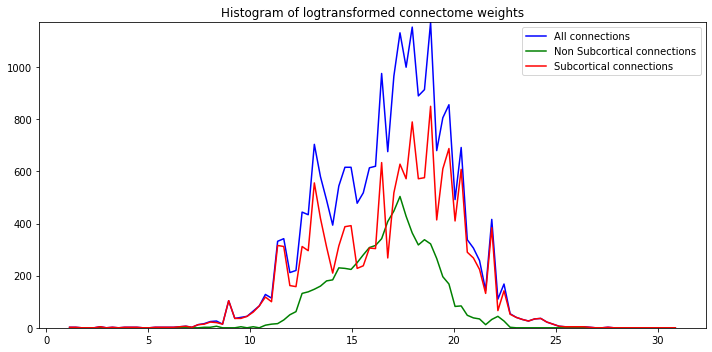

In [5]:
connectome = logprocess_weights(connectome, inds, print_flag=True, plotter=plotter)


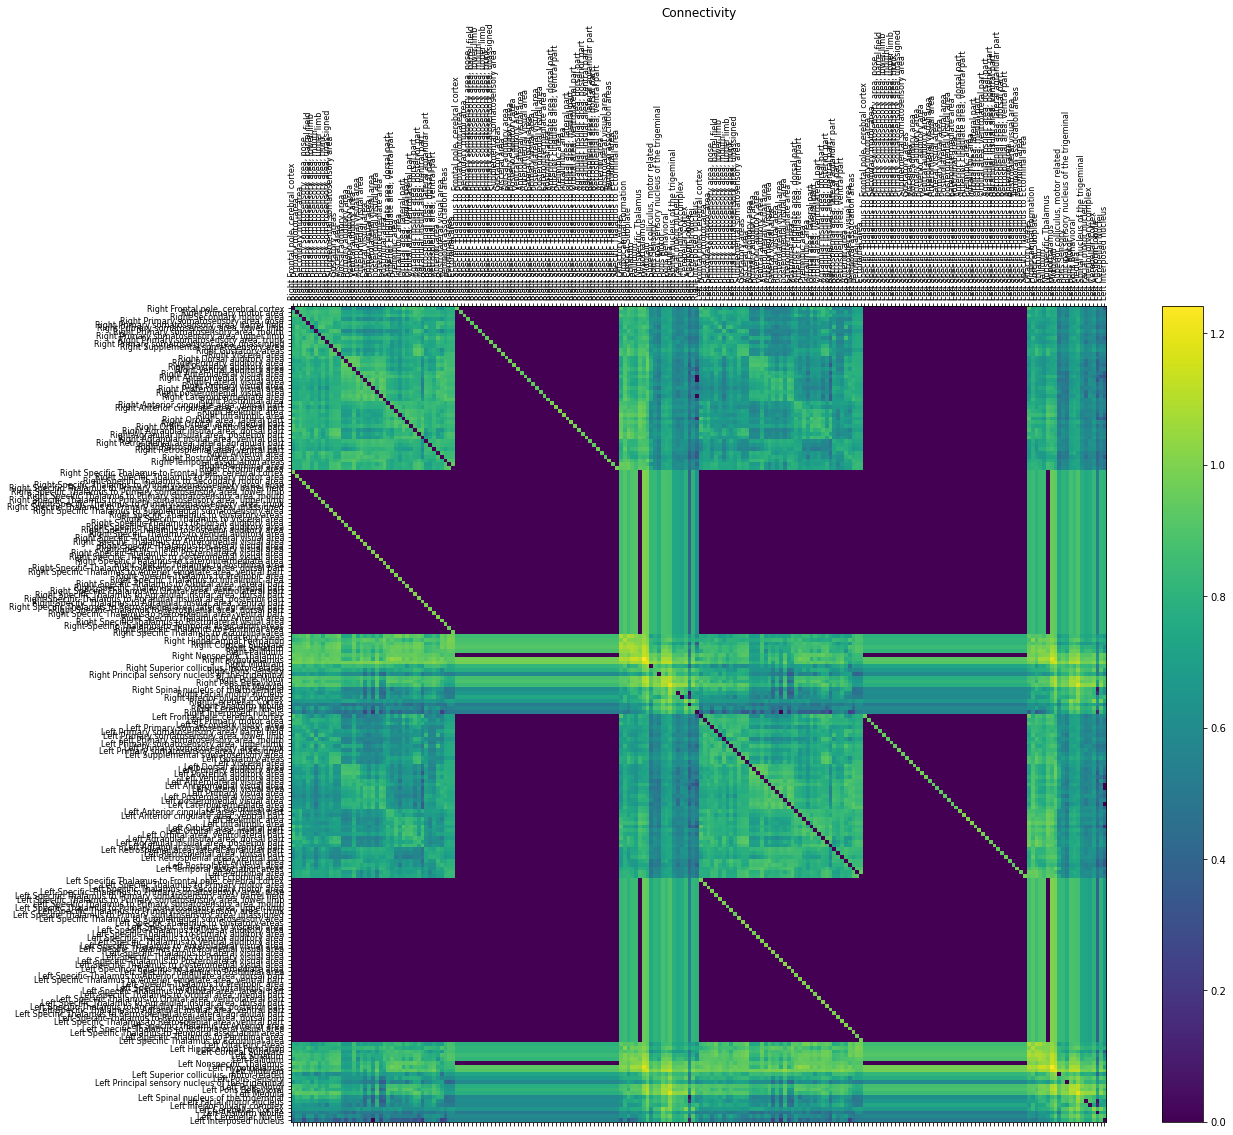

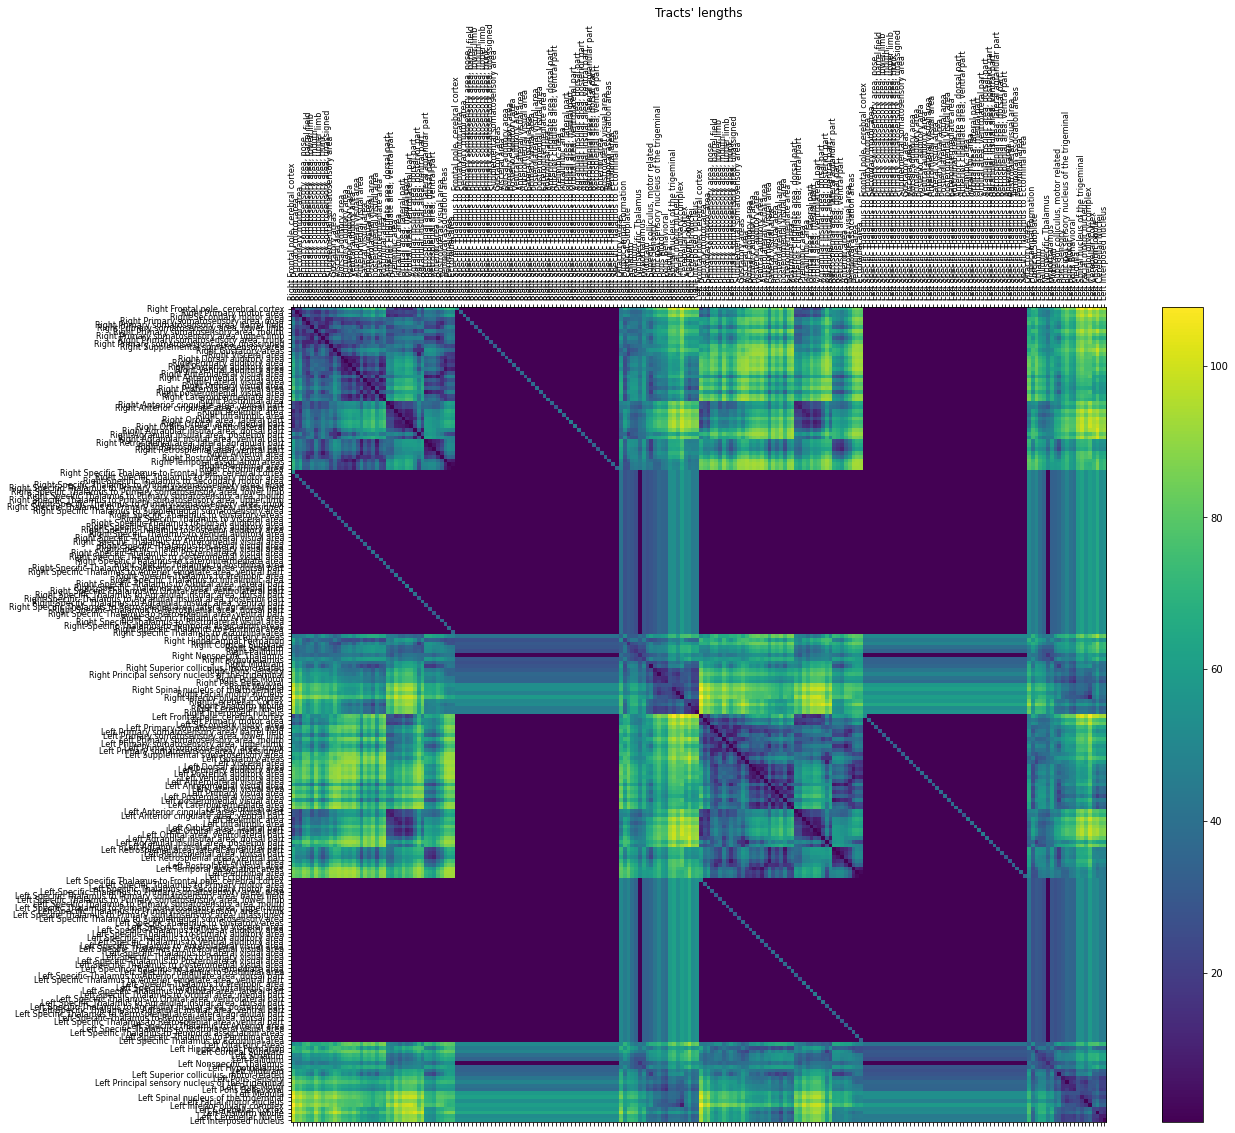

In [6]:
connectivity = build_connectivity(connectome, inds, config, print_flag=True, plotter=plotter)


In [7]:
weights = connectivity.weights

# Indices of cortical and subcortical regions excluding specific thalami
inds["non_thalamic"] = np.unique(inds['crtx'].tolist() + inds["subcrtx_not_thalspec"].tolist()).astype('i')
 
# Remove connections from/to specific thalamic
indegree = (connectivity.weights[inds["non_thalamic"]][:, inds["non_thalamic"]]).sum(axis=1)
mean_indegree = indegree.mean()
std_indegree = np.std(indegree)
FICindegree = (indegree - indegree.min())/std_indegree

In [8]:
[mean_indegree, std_indegree, indegree.min()]

[94.30765876900139, 9.47488479301673, 67.84094129332631]

In [9]:
-2.0 * (1 + np.array([FICindegree.min(), np.percentile(FICindegree, 1), np.percentile(FICindegree, 5), 
 np.percentile(FICindegree, 10), np.percentile(FICindegree, 25), 
 np.percentile(FICindegree, 50), 
 np.percentile(FICindegree, 75), np.percentile(FICindegree, 90), 
 np.percentile(FICindegree, 95), np.percentile(FICindegree, 99), FICindegree.max()]))

array([ -2.        ,  -2.34676093,  -5.58104406,  -6.02152124,
        -6.65713468,  -7.22031162,  -7.62197116, -11.02166465,
       -11.51624279, -13.0916118 , -13.31797941])

In [10]:
model = build_model(connectivity.number_of_regions, inds, maps, config)


/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/node_set.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, nodes=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/devices.py:953: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, device_set=pd.Series(), **kwargs):


2022-05-31 17:37:03,931 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 0c33fd1e-c6a1-4b9c-9b09-aee68471889d'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: ff0ff134-cc6e-458a-a001-998b767a95b3
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: ad39e727-193f-4ca6-89

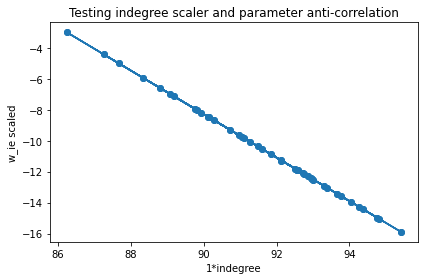

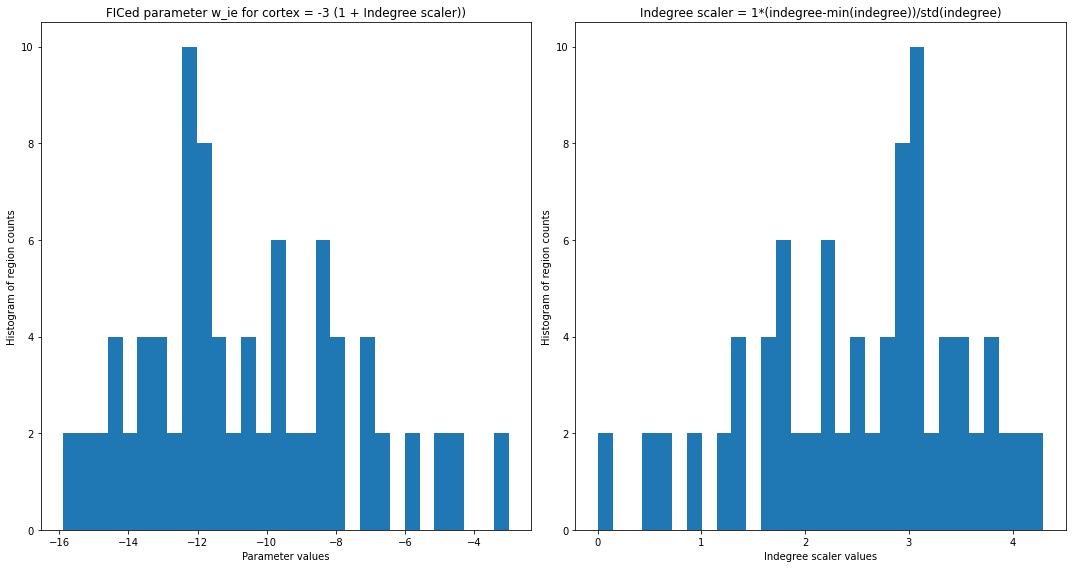

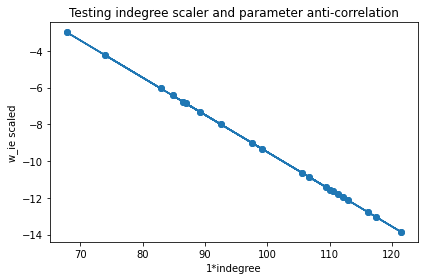

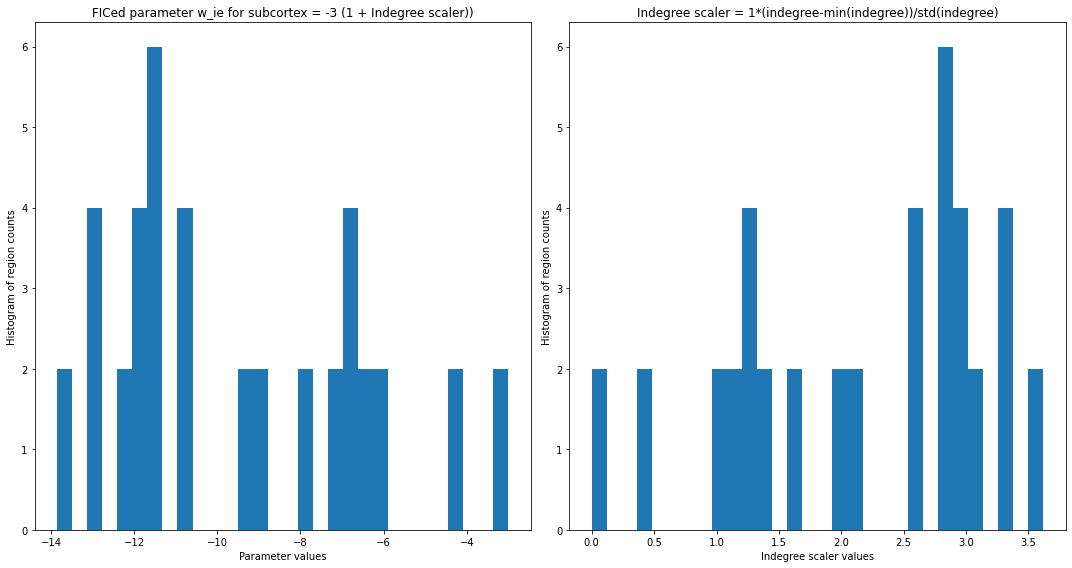

In [11]:
simulator = build_simulator(connectivity, model, inds, maps, config, print_flag=True, plotter=plotter)


# Configure simulator, simulate, gather results

In [12]:
# Simulate!

results, transient = simulate(simulator, config, print_flag=True)



Simulated in 260.792525 secs!


# Compute data and target PSDs and compare:

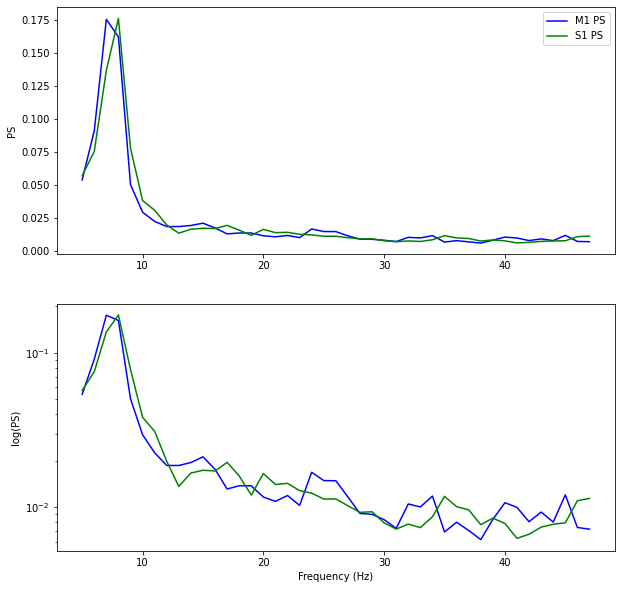

In [13]:
PSD_target = compute_target_PSDs(config, write_files=True, plotter=plotter)

(4, 1025)


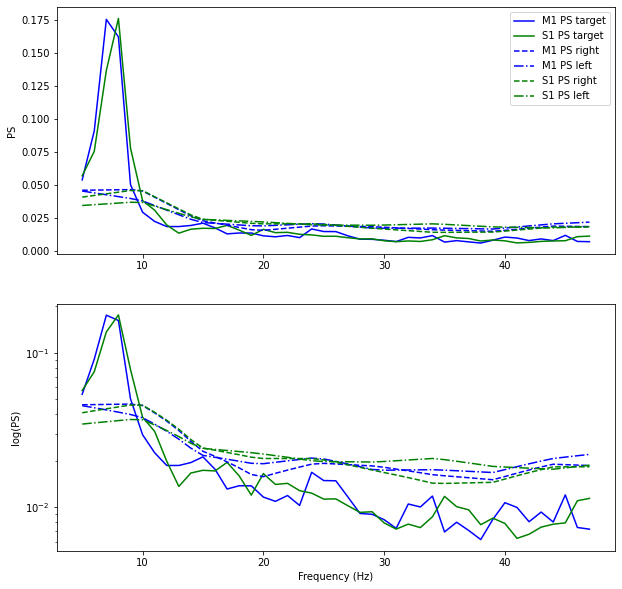

In [14]:
PSD = compute_data_PSDs(results[0], PSD_target, inds, config, transient, plotter=plotter)

# Plot results and write them to HDF5 files

In [15]:
from scipy.io import savemat
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 2
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# plot_write_results(results, simulator, populations=populations, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [16]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.tvb.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = None
bold_ts = None

if results is not None:
    source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    t = source_ts.time

    # Write to file
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                        connectivity=source_ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    print("Raw ts:\n%s" % str(source_ts))
    
    if len(results) > 1:
        bold_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
                data=results[1][1], time=results[1][0],
                connectivity=simulator.connectivity,
                labels_ordering=["Time", "State Variable", "Region", "Neurons"],
                labels_dimensions={"State Variable": ["BOLD"],
                                   "Region": simulator.connectivity.region_labels.tolist()})
        bold_ts.configure()

        bold_t = source_ts.time

        # Write to file
        if writer:
            writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(bold_ts._data,
                                                                            connectivity=bold_ts.connectivity),
                                   os.path.join(config.out.FOLDER_RES, bold_ts.title)+".h5")
        print("BOLD ts:\n%s" % str(bold_ts))
    

2022-05-31 17:41:26,909 - INFO - tvb.storage.h5.encryption.data_encryption_handler - Cannot import syncrypto library.
Raw ts:
TimeSeriesRegion (
  Dimensions .......... ['Time', 'State Variable', 'Region', 'Neurons']
  Length .............. 44000
  Region Mapping ...... None
  Region Mapping Volume  None
  Sample period ....... 0.09999999999999999
  Source Connectivity . Connectivity gid: ad39e727-193f-4ca6-89f7-de7ccee00060
  Time units .......... ms
  Time-series name .... Region Time Series
  Time-series type .... TimeSeriesRegion
  [min, median, max] .. [-14.3716, -0.241284, 2.87166]
  dtype ............... float64
  shape ............... (44000, 3, 214, 1)
)


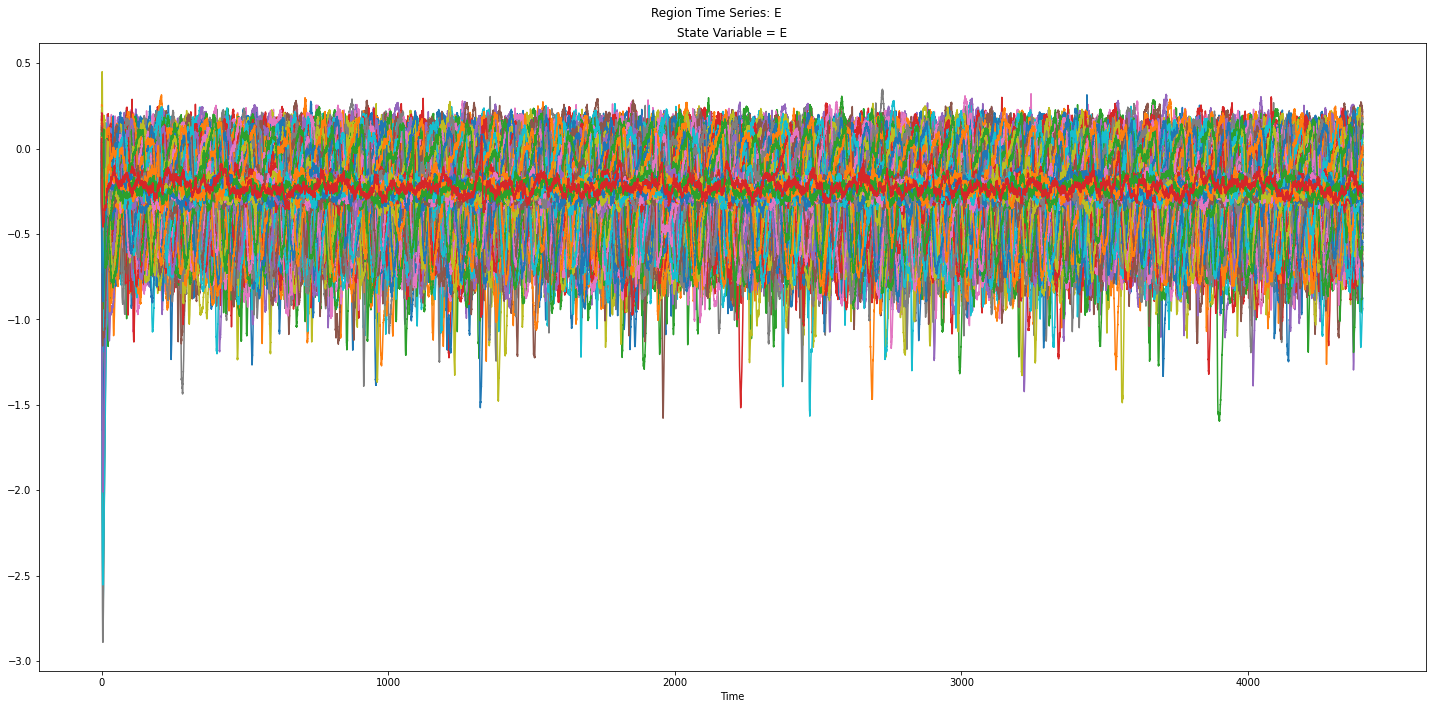

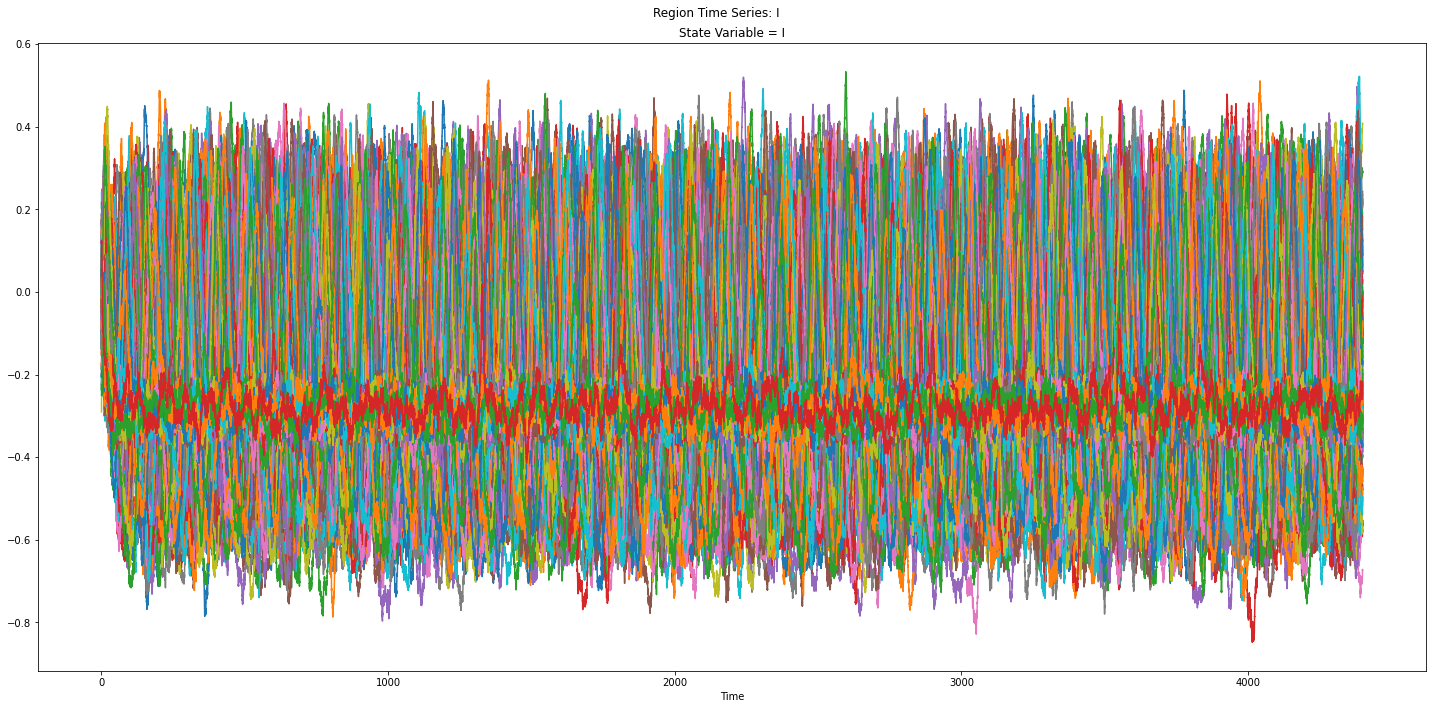

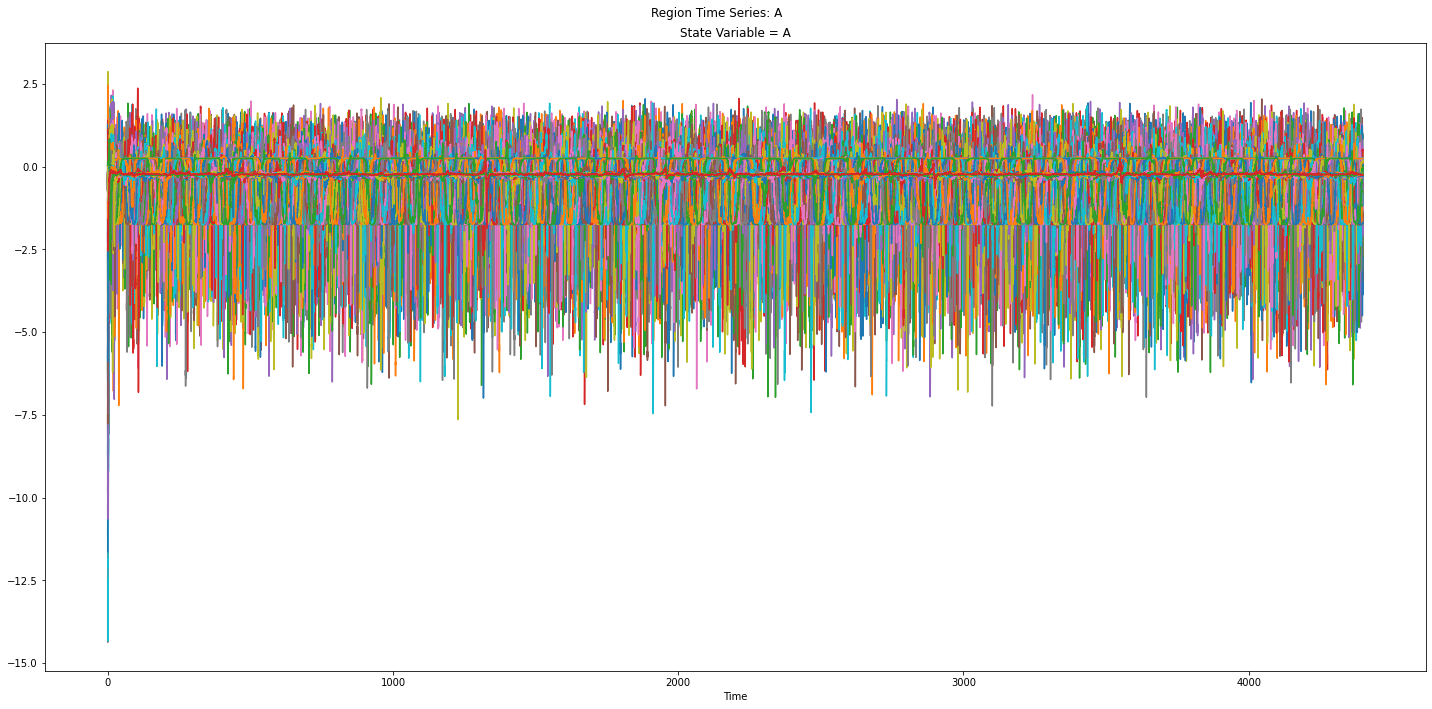

In [17]:
# Plot TVB time series
if source_ts is not None:
    source_ts[:, :, :, :].plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

2022-05-31 17:42:03,913 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-31 17:42:03,920 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-31 17:42:04,436 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-31 17:42:04,906 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


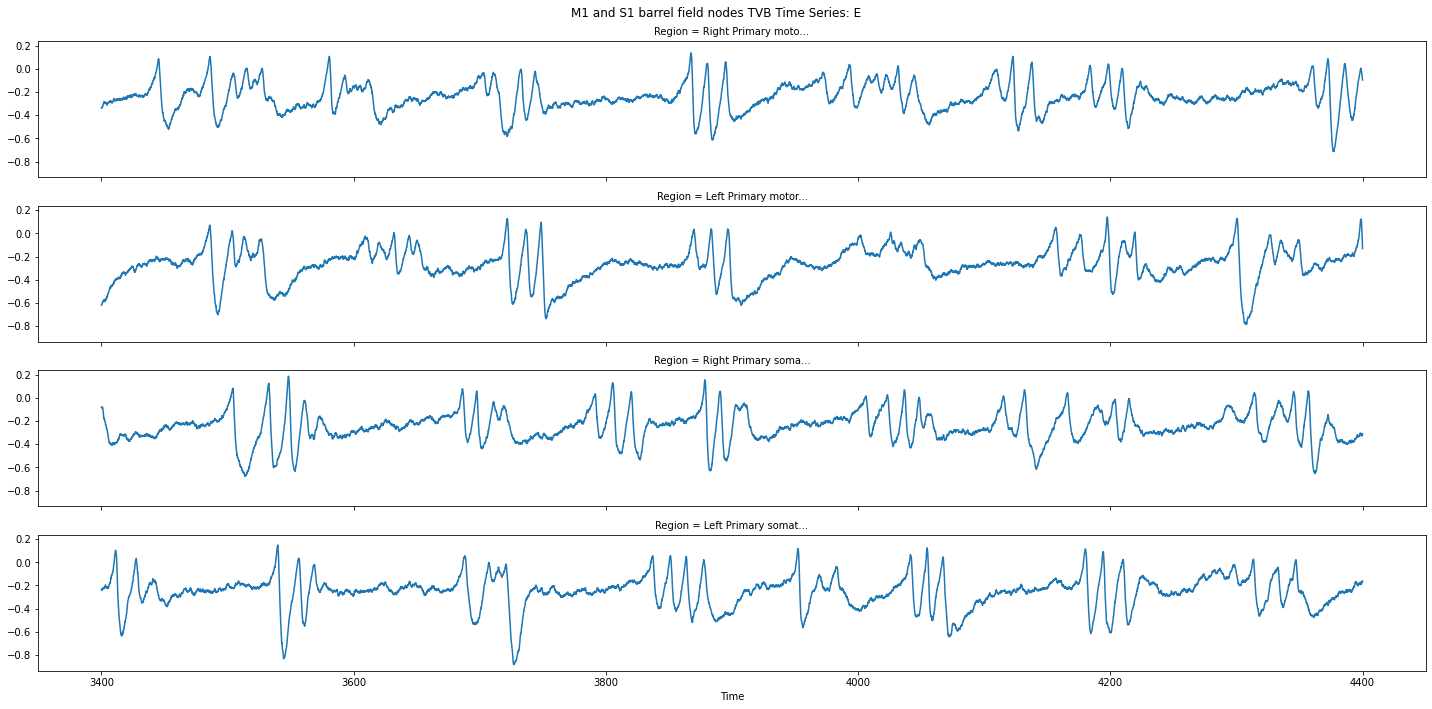

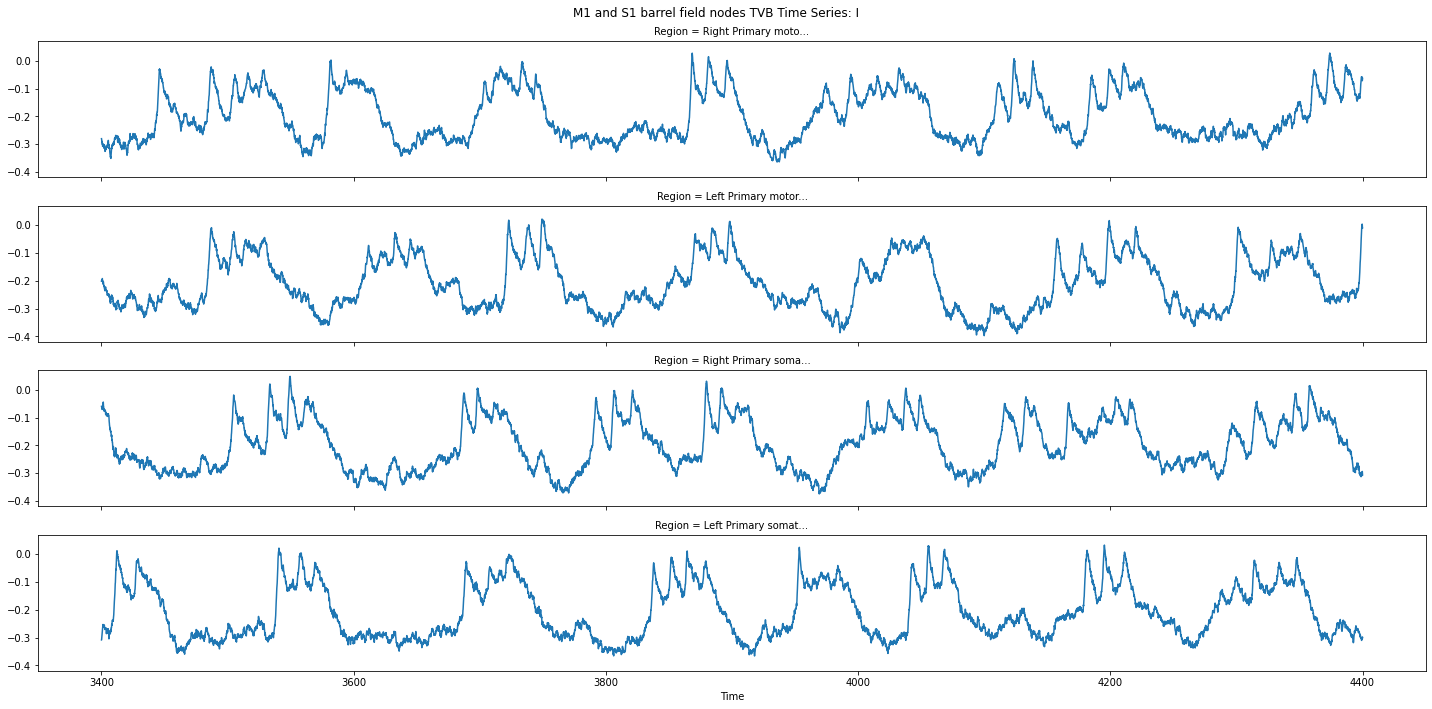

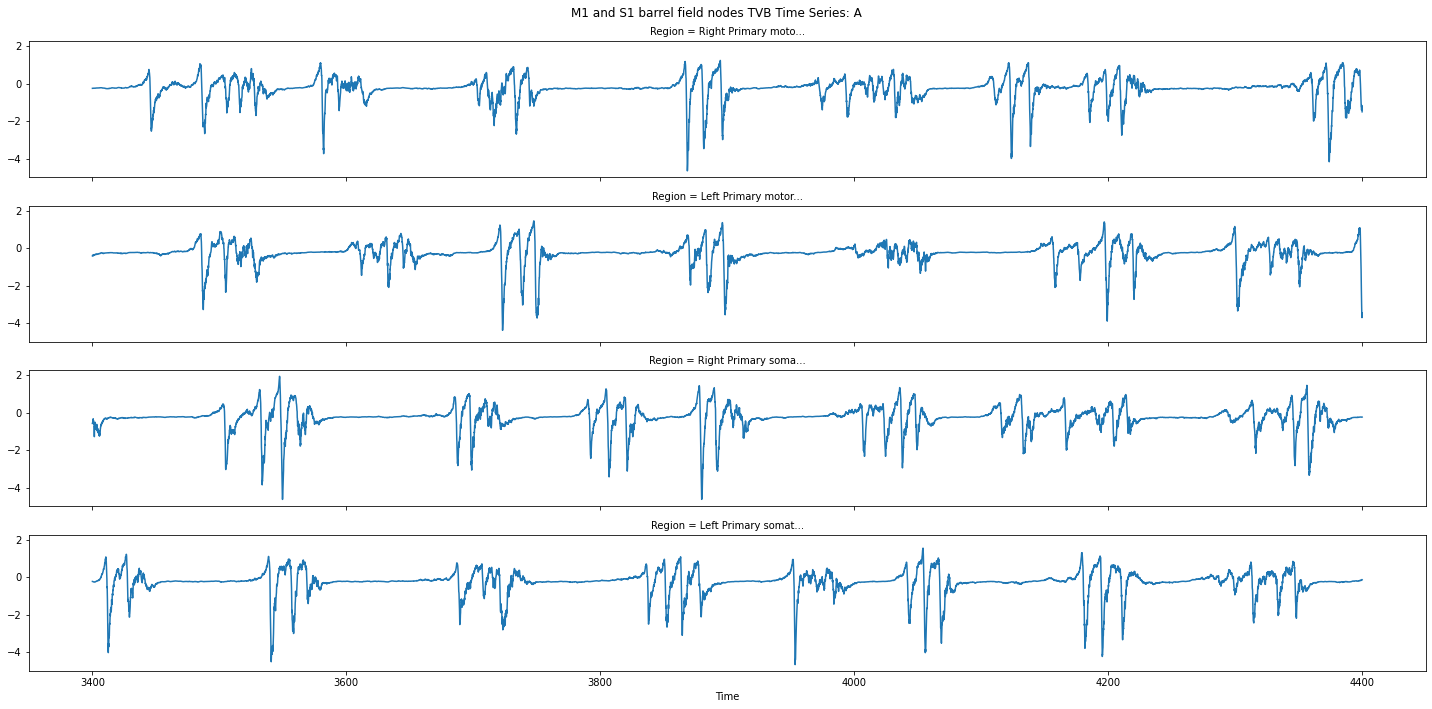

In [18]:
# Focus on the m1 and s1 barrel field nodes: 
if source_ts is not None:
    source_ts_m1s1brl = source_ts[-10000:, :, inds["m1s1brl"]]
    source_ts_m1s1brl.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_m1s1brl.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="M1 and S1 barrel field nodes TVB Time Series");

In [19]:
# Focus on the m1 and s1 barrel field nodes: raster plot
if source_ts is not None and source_ts_m1s1brl.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_m1s1brl.plot_raster(plotter_config=plotter.config, 
                                  per_variable=source_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS,
                                  figsize=FIGSIZE, figname="M1 and S1 barrel field nodes TVB Time Series Raster");

2022-05-31 17:42:06,373 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-31 17:42:06,382 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-31 17:42:06,790 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-31 17:42:07,441 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


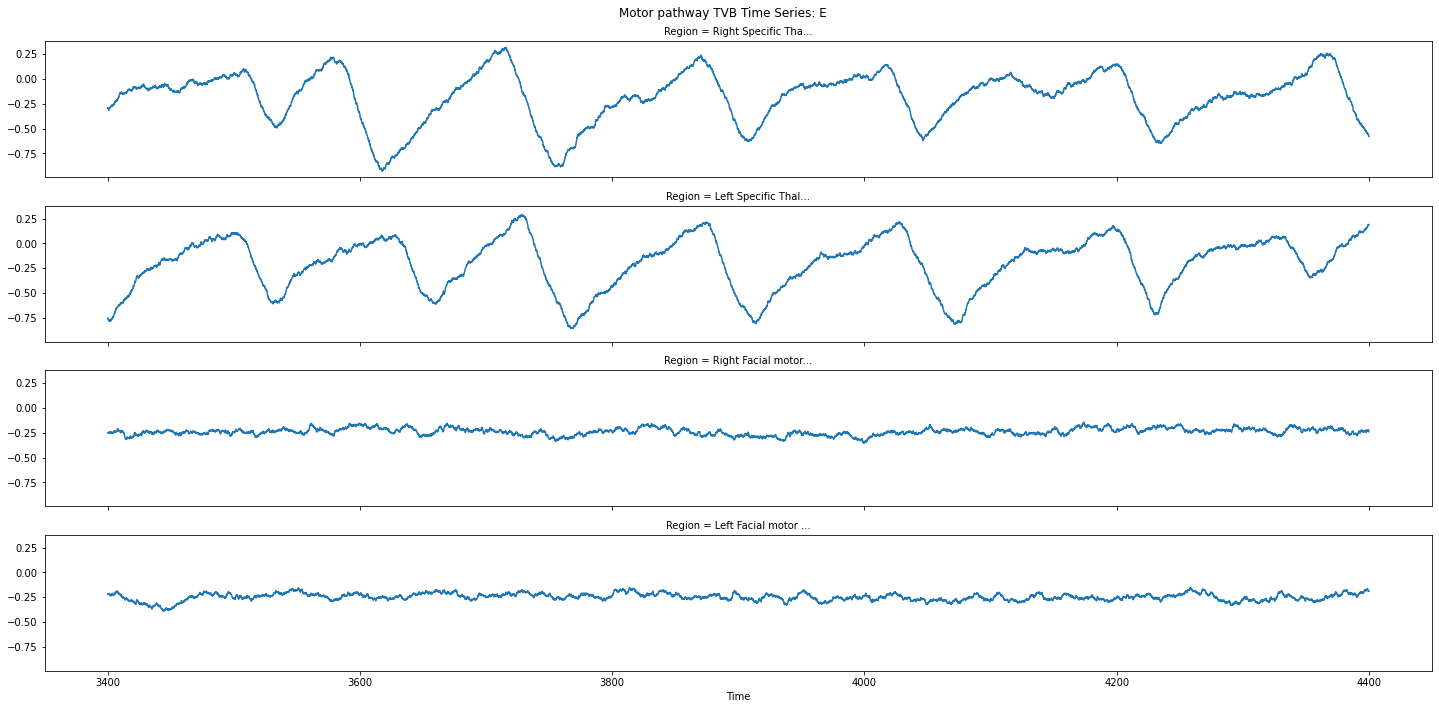

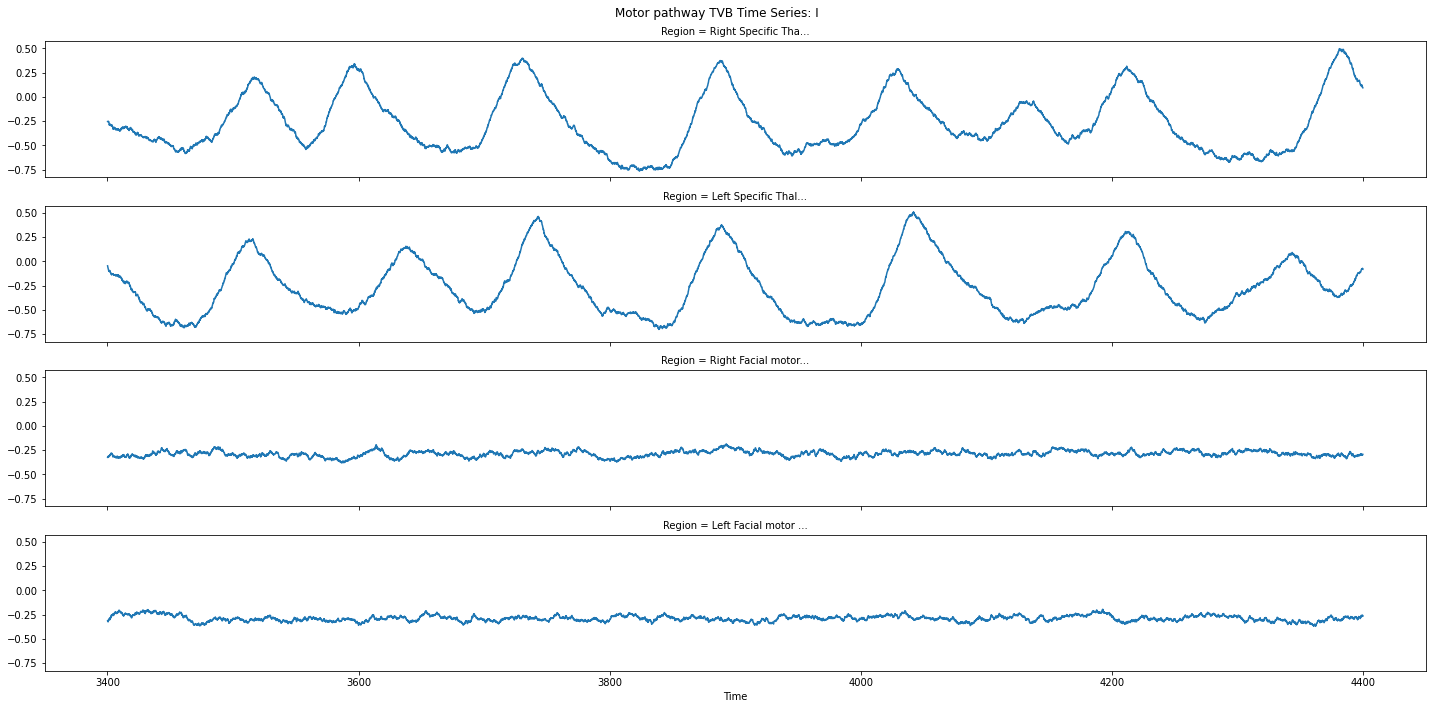

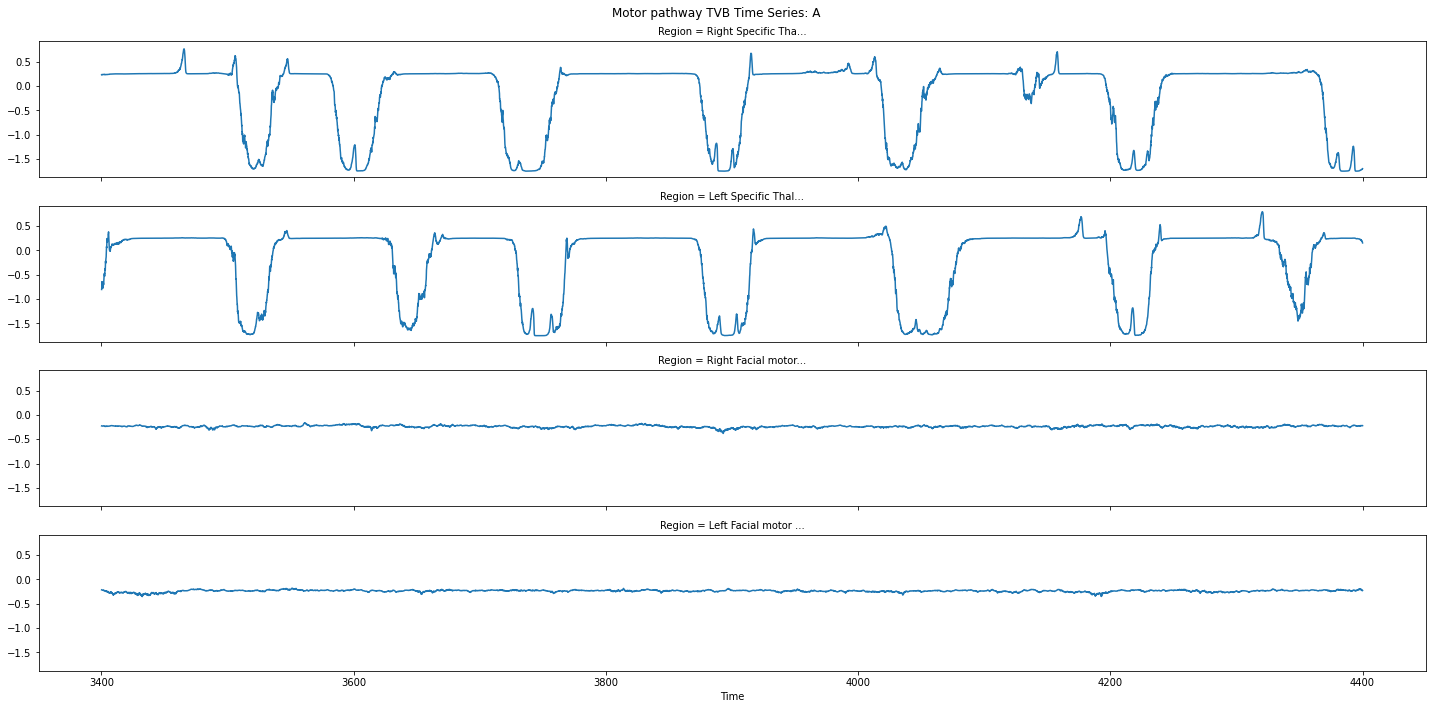

In [20]:
# Focus on the the motor pathway: 
if source_ts is not None:
    source_ts_motor = source_ts[-10000:, :, inds["motor"]]
    source_ts_motor.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_motor.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_motor.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Motor pathway TVB Time Series");

In [21]:
# Focus on the motor pathway: raster plot
if source_ts_motor is not None and source_ts_motor.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_motor.plot_raster(plotter_config=plotter.config, 
                                  per_variable=source_ts_motor.shape[1] > MAX_VARS_IN_COLS,
                                  figsize=FIGSIZE, figname="Motor pathway TVB Time Series Raster");

2022-05-31 17:42:08,779 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-31 17:42:08,785 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-31 17:42:09,329 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2022-05-31 17:42:09,861 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


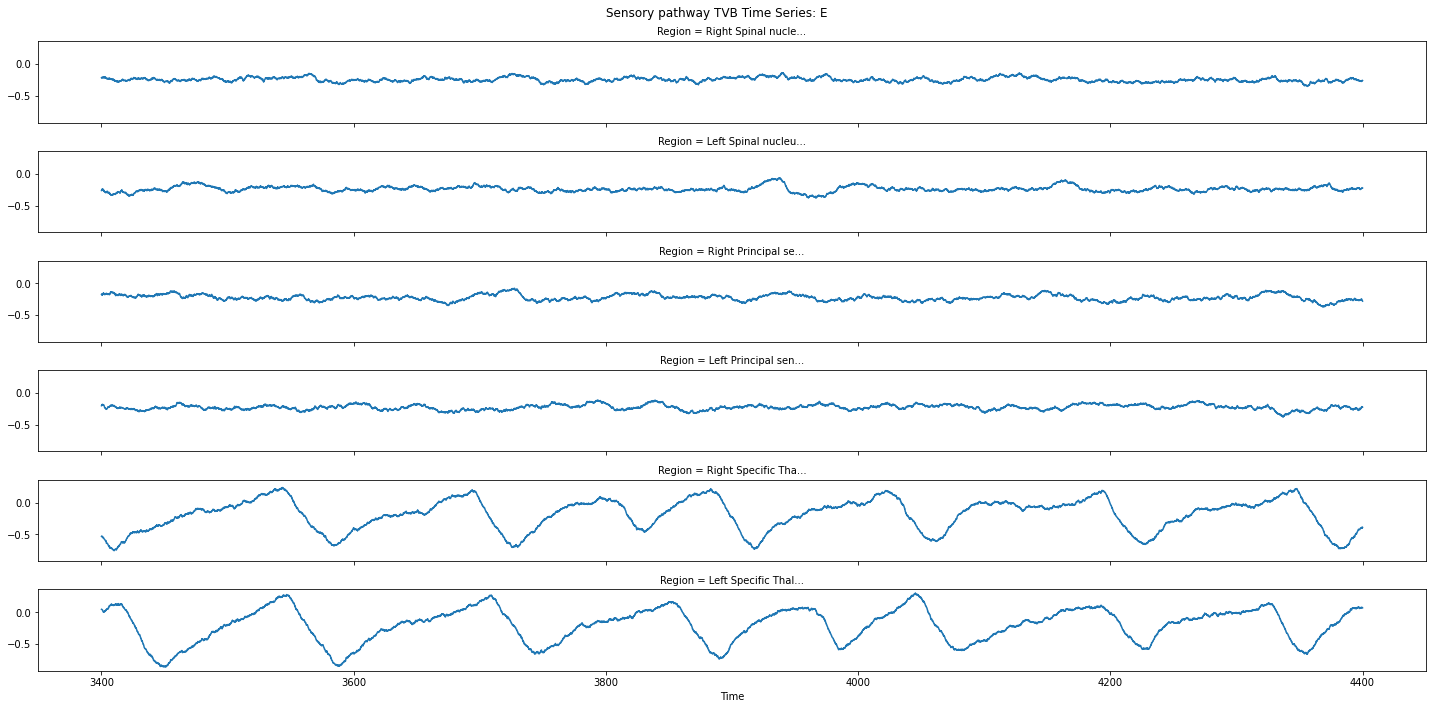

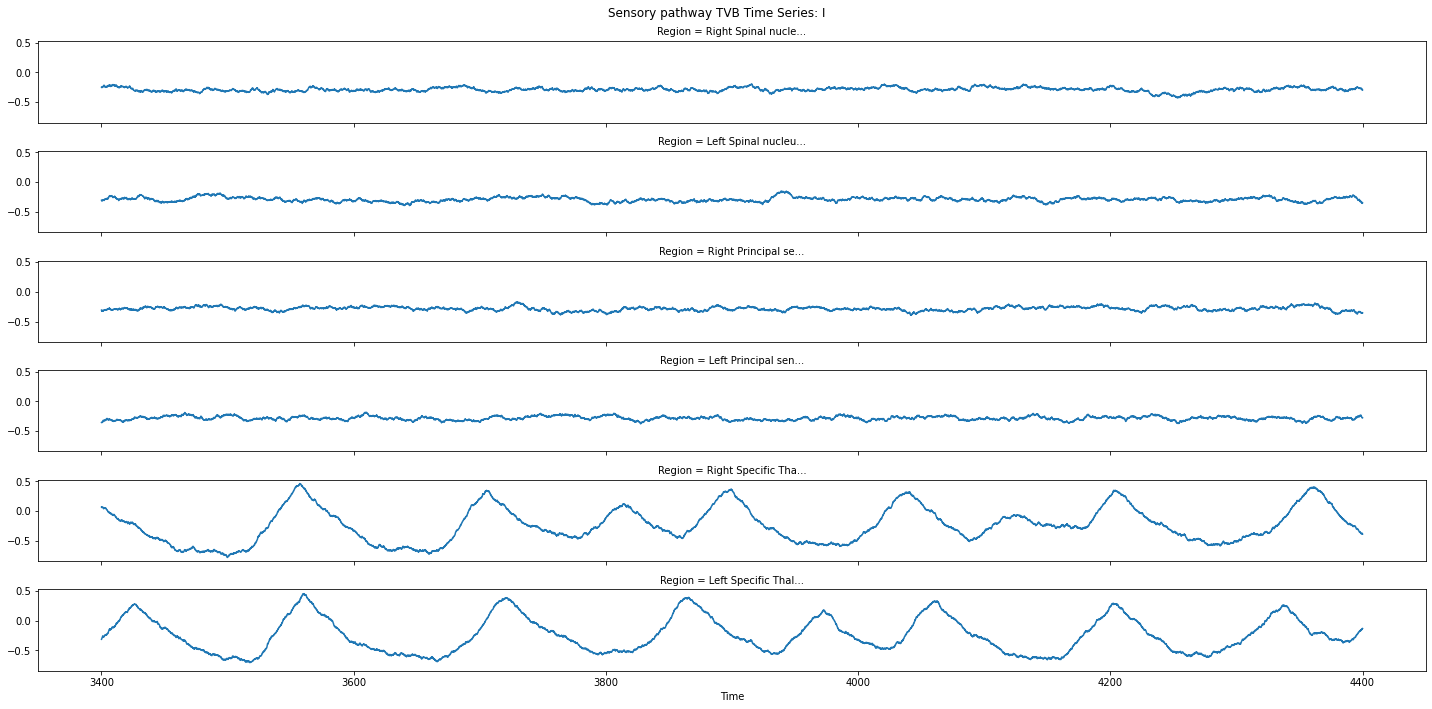

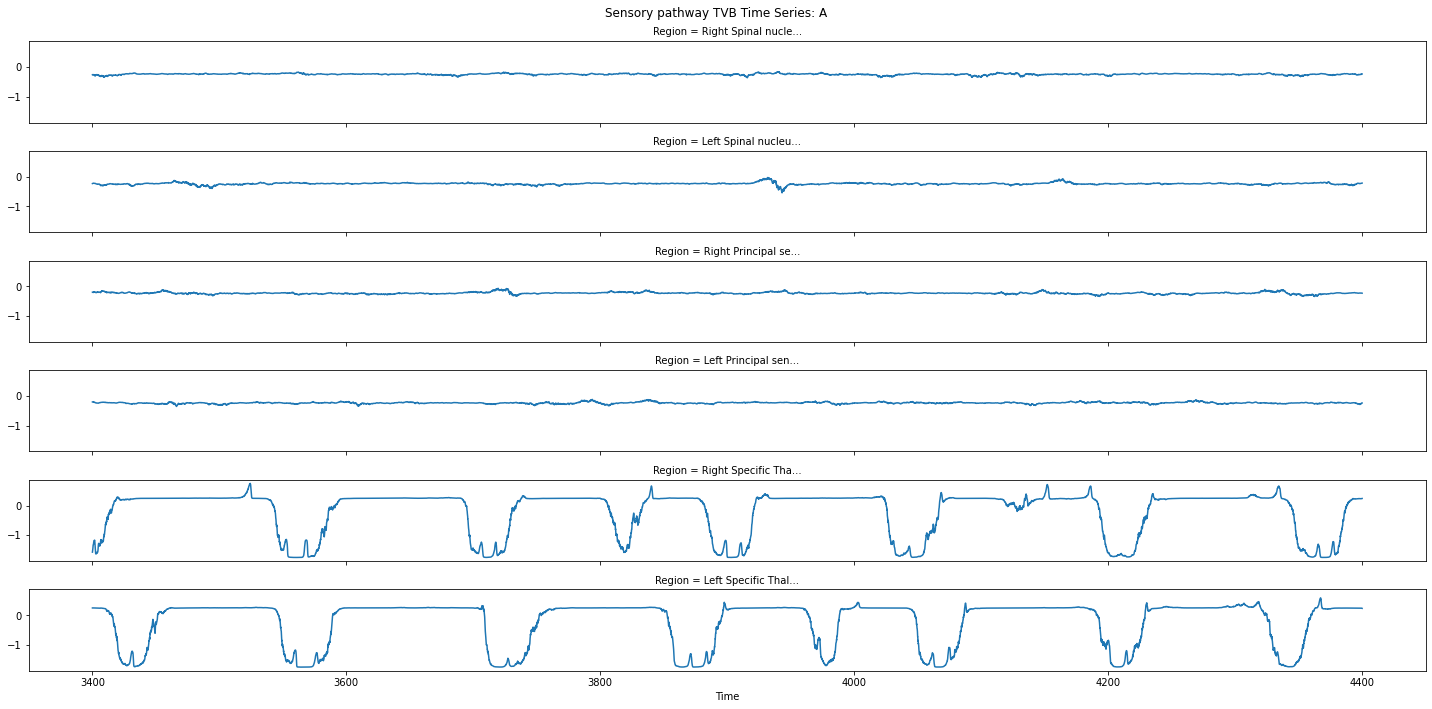

In [22]:
# Focus on the sensory pathway: 
if source_ts is not None:
    source_ts_sens = source_ts[-10000:, :, inds["sens"]]
    source_ts_sens.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_sens.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_sens.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Sensory pathway TVB Time Series");

In [23]:
# Focus on the sensory pathway: raster plot
if source_ts is not None and source_ts_sens.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_sens.plot_raster(plotter_config=plotter.config, 
                               per_variable=source_ts_sens.shape[1] > MAX_VARS_IN_COLS,
                               figsize=FIGSIZE, figname="Sensory pathway TVB Time Series Raster");

In [24]:
# bold_ts TVB time series
if bold_ts is not None:
    bold_ts.plot_timeseries(plotter_config=plotter.config, 
                            hue="Region" if bold_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                            per_variable=bold_ts.shape[1] > MAX_VARS_IN_COLS, 
                            figsize=FIGSIZE);

In [25]:
# # Focus on the m1 and s1 barrel field nodes: 
# if bold_ts is not None:
#     bold_ts_m1s1brl = bold_ts[-10000:, :, inds["m1s1brl"]]
#     bold_ts_m1s1brl.plot_timeseries(plotter_config=plotter.config, 
#                                     hue="Region" if bold_ts_m1s1brl.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                     per_variable=bold_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS, 
#                                     figsize=FIGSIZE, figname="M1 and S1 barrel field nodes BOLD Time Series");

In [26]:
# # Focus on the m1 and s1 barrel field nodes: raster plot
# if bold_ts is not None and bold_ts_m1s1brl.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     bold_ts_m1s1brl.plot_raster(plotter_config=plotter.config, 
#                                 per_variable=bold_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS,
#                                 figsize=FIGSIZE, figname="M1 and S1 barrel field nodes BOLD Time Series Raster");

In [27]:
# # Focus on the the motor pathway: 
# if bold_ts is not None:
#     bold_ts_motor = bold_ts[-10000:, :, inds["motor"]]
#     bold_ts_motor.plot_timeseries(plotter_config=plotter.config, 
#                                    hue="Region" if bold_ts_motor.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                    per_variable=bold_ts_motor.shape[1] > MAX_VARS_IN_COLS, 
#                                    figsize=FIGSIZE, figname="Motor pathway BOLD Time Series");

In [28]:
# # Focus on the motor pathway: raster plot
# if bold_ts is not None and bold_ts_motor.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     bold_ts_motor.plot_raster(plotter_config=plotter.config, 
#                               per_variable=bold_ts_motor.shape[1] > MAX_VARS_IN_COLS,
#                               figsize=FIGSIZE, figname="Motor pathway BOLD Time Series Raster");

In [29]:
# # Focus on the sensory pathway: 
# if bold_ts is not None:
#     bold_ts_sens = bold_ts[-10000:, :, inds["sens"]]
#     bold_ts_sens.plot_timeseries(plotter_config=plotter.config, 
#                                  hue="Region" if bold_ts_sens.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                  per_variable=bold_ts_sens.shape[1] > MAX_VARS_IN_COLS, 
#                                  figsize=FIGSIZE, figname="Sensory pathway BOLD Time Series");

In [30]:
# # Focus on the sensory pathway: raster plot
# if bold_ts is not None and bold_ts_sens.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     bold_ts_sens.plot_raster(plotter_config=plotter.config, 
#                              per_variable=bold_ts_sens.shape[1] > MAX_VARS_IN_COLS,
#                              figsize=FIGSIZE, figname="Sensory pathway BOLD Time Series Raster");

### Interactive time series plot

In [31]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

In [32]:
# # For interactive plotting:
# %matplotlib notebook  


# from tvb.datatypes.time_series import TimeSeries
# from tvb.contrib.scripts.plot.power_spectra_interactive import PowerSpectraInteractive

# tsr = TimeSeries(data=source_ts[1000:, 0, inds["m1s1brl"]]._data.values, sample_period=source_ts.sample_period)
# psi = PowerSpectraInteractive()
# psi.time_series = tsr
# psi.window_length = 1000.0
# psi.show()
# from ipywidgets import interact, widgets as ip_widgets
# from IPython.display import display

# textRegions = ip_widgets.Text(
#     value='',
#     placeholder='Regions Slicer',
#     description='start:stop:step',
#     disabled=False
# )

# textFreqs = ip_widgets.Text(
#     value='',
#     placeholder='Frequency Range',
#     description='f_min, f_max',
#     disabled=False
# )

# def callbackRegions(wdgt):
#     # replace by something useful
#     psi.update_regions(wdgt.value)

# def callbackFreqs(wdgt):
#     # replace by something useful
#     psi.update_freq_range(wdgt.value)
    
# textRegions.on_submit(callbackRegions)
# textFreqs.on_submit(callbackFreqs)

# display(textRegions)
# display(textFreqs)



2022-05-31 17:42:11,415 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


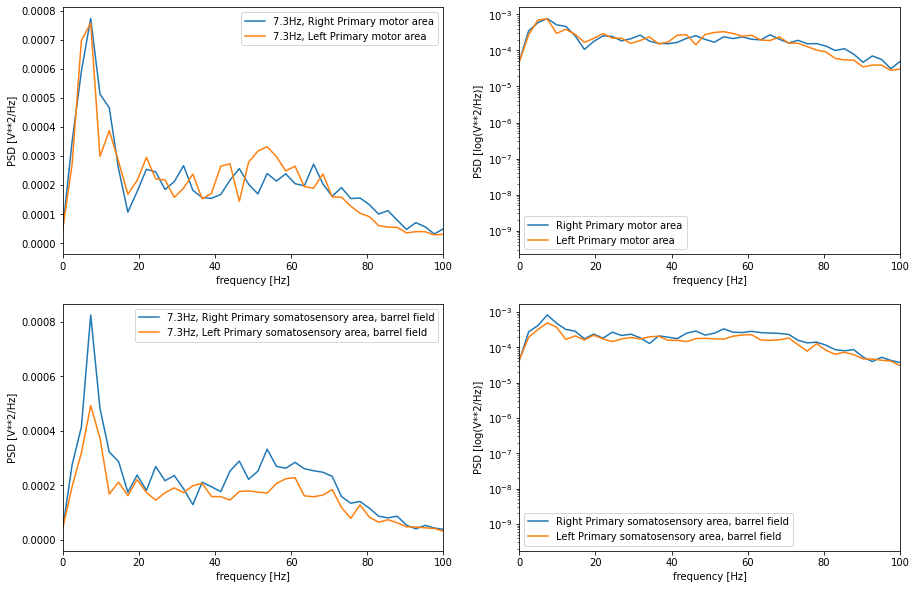

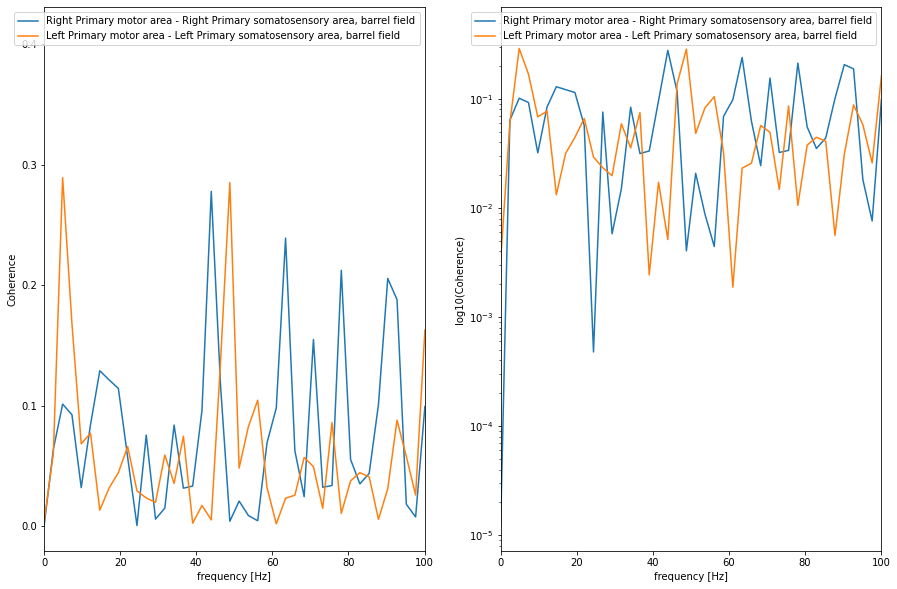

In [33]:
%matplotlib inline 

from examples.tvb_nest.notebooks.cerebellum.utils import  compute_plot_selected_spectra_coherence, compute_plot_ica

NPERSEG = np.array([256, 512, 1024, 2048, 4096])
NPERSEG = NPERSEG[np.argmin(np.abs(NPERSEG - (source_ts.shape[0]-transient/config.DEFAULT_DT)))]

# Power Spectra and Coherence for M1 - S1 barrel field
compute_plot_selected_spectra_coherence(source_ts, inds["m1s1brl"], 
                                        transient=transient, nperseg=NPERSEG, fmin=0.0, fmax=100.0)

2022-05-31 17:42:12,976 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


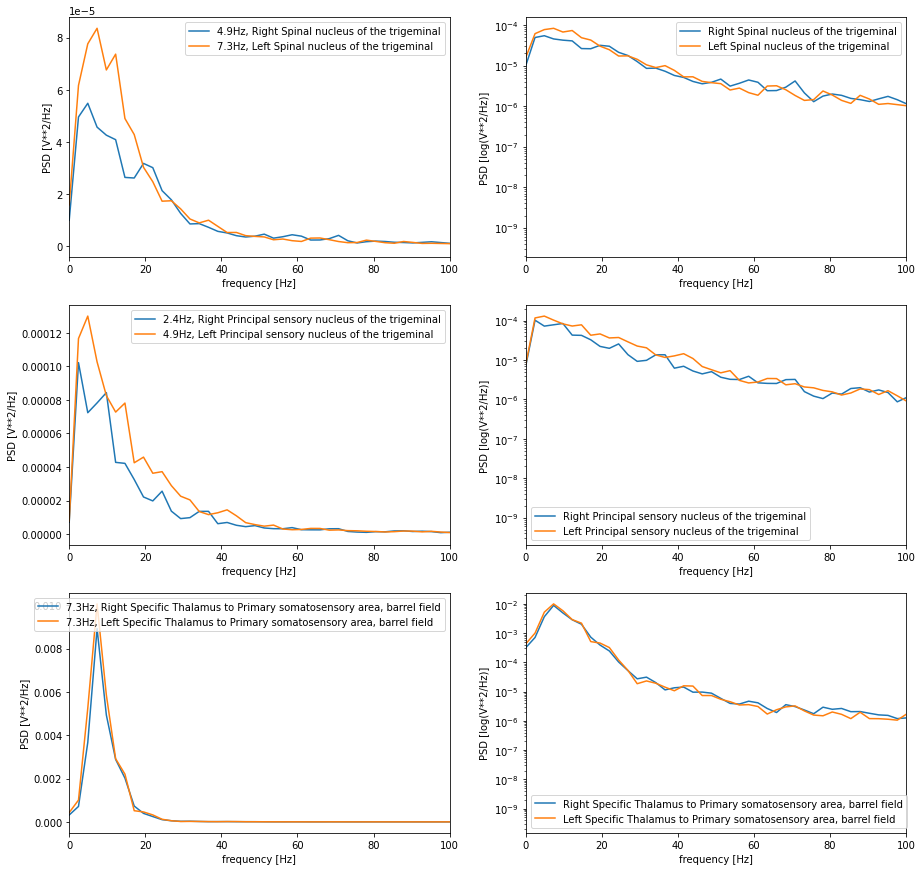

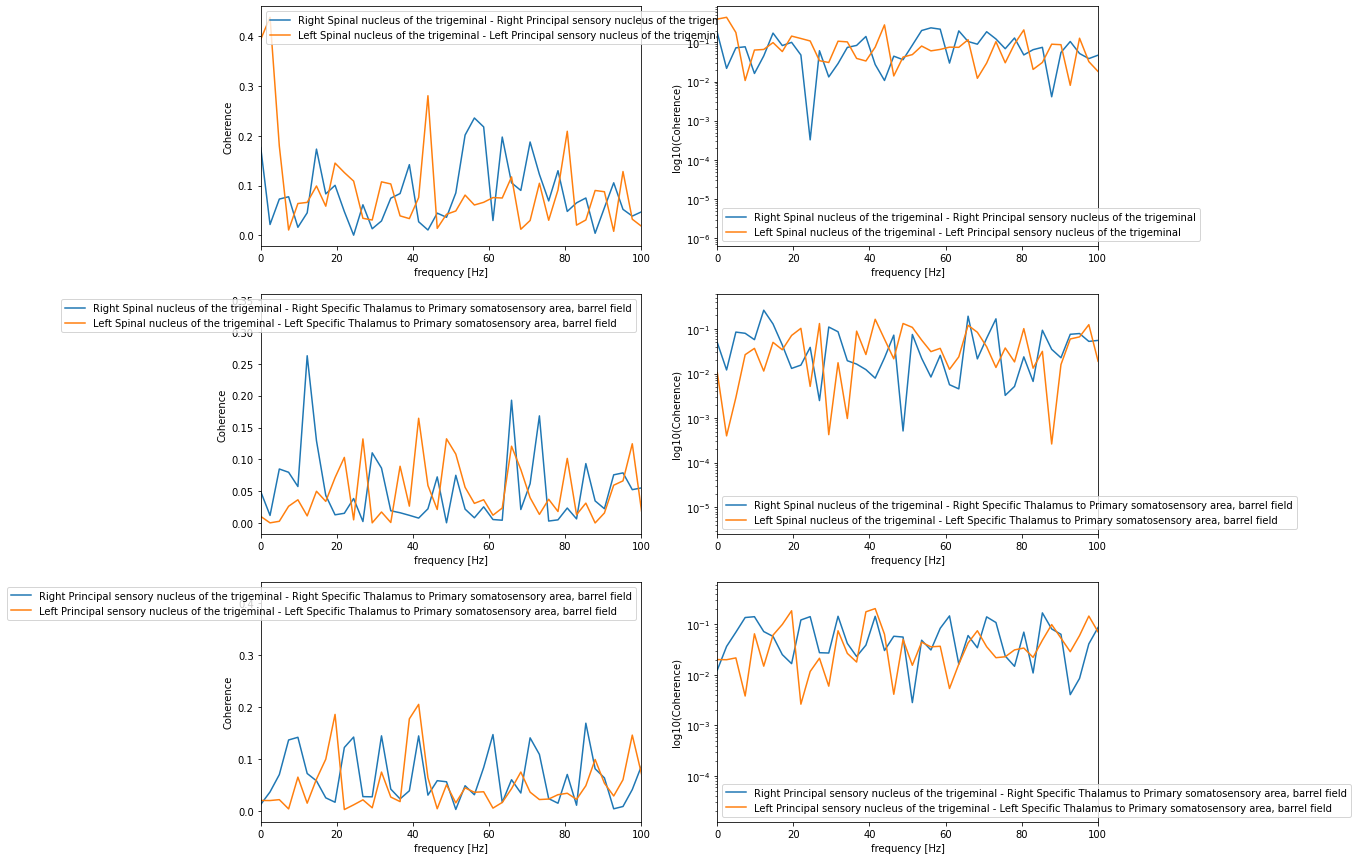

In [34]:
# Power Spectra and Coherence along the sensory pathway:
# for Medulla SPV, Sensory PONS
compute_plot_selected_spectra_coherence(source_ts, inds["sens"], 
                                        transient=transient, nperseg=NPERSEG, fmin=0.0, fmax=100.0)

/home/docker/env/neurosci/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


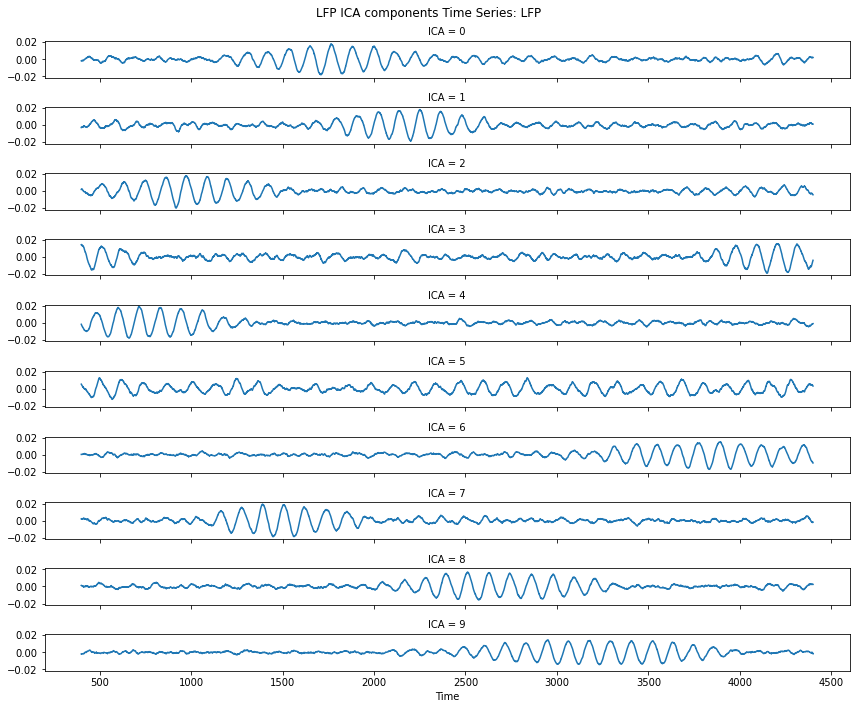

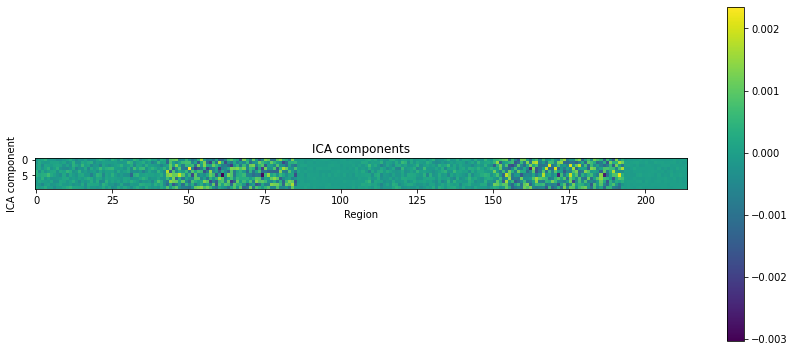

In [35]:
plotter.config.DEFAULT_SIZE = (12, 10)  # FIGSIZE
if source_ts is not None:
    # LFP (E) ICA:
    lfp_ica_comps, lfp_ics_ts, lfp_ica = compute_plot_ica(source_ts[transient:].data[:, 0, :, 0].squeeze(), 
                                                          source_ts[transient:].time,
                                                          variable="LFP", n_components=10, plotter=plotter)
    

In [36]:
if bold_ts is not None:    
    # BOLD ICA:
    bold_ica_comps, bold_ics_ts, bold_ica = compute_plot_ica(bold_ts.data[:, 0, :, 0].squeeze(), bold_ts.time,
                                                             variable="BOLD", n_components=10, plotter=plotter)
    

# References

1 Sanz Leon P, Knock SA , Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK. 2013. <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling and multimodal neuroimaging. <br>
  Brain Connectivity 3:121–145. <br>

3 Griffiths JD, McIntosh AR, Lefebvre J. 2020.   <br>
  A Connectome-Based, Corticothalamic Model of State- <br>
  and Stimulation-Dependent Modulation of Rhythmic Neural Activity and Connectivity <br>
  Frontiers in Computational Neuroscience (vol. 14. doi: 10.3389/fncom.2020.575143) <br>
  https://www.frontiersin.org/articles/10.3389/fncom.2020.575143/full#h12
  
4 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>

(34000, 86)
(34000, 42)
(34000, 86)


/home/docker/env/neurosci/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


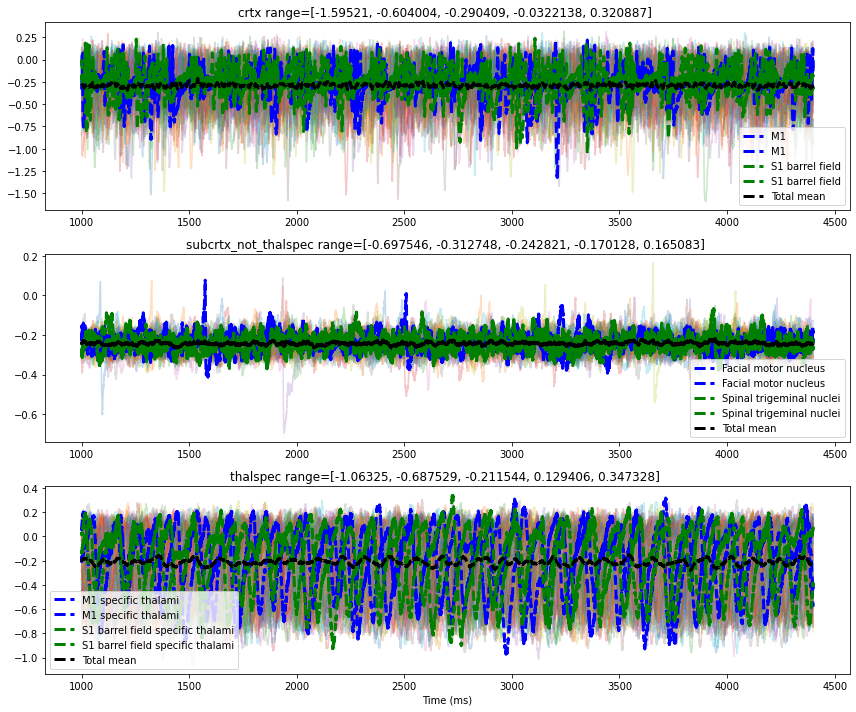

In [37]:
%matplotlib inline

import matplotlib.pyplot as plt

data = source_ts.data
time = source_ts.time

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
for iT, regs in enumerate(["crtx", "subcrtx_not_thalspec", "thalspec"]):
    transient = 10000
    dat = data[transient:, 0, inds[regs]].squeeze()
    print(dat.shape)
    axes[iT].plot(time[transient:], dat, alpha=0.25)
    if iT == 0:
        axes[iT].plot(time[transient:], data[transient:, 0, inds["m1"]].squeeze(), 
                      'b--', linewidth=3, label='M1')
        axes[iT].plot(time[transient:], data[transient:, 0, inds["s1brl"]].squeeze(), 
                      'g--', linewidth=3, label='S1 barrel field')
    elif iT == 1:
        axes[iT].plot(time[transient:], data[transient:, 0, inds["facial"]].squeeze(), 
                      'b--', linewidth=3, label='Facial motor nucleus')
        axes[iT].plot(time[transient:], data[transient:, 0, inds["trigeminal"]].squeeze(), 
                      'g--', linewidth=3, label='Spinal trigeminal nuclei')
    else:
        axes[iT].plot(time[transient:], data[transient:, 0, [44, 166]].squeeze(), 
                      'b--', linewidth=3, label='M1 specific thalami')
        axes[iT].plot(time[transient:], data[transient:, 0, [47, 169]].squeeze(), 
                      'g--', linewidth=3, label='S1 barrel field specific thalami')
        axes[iT].set_xlabel('Time (ms)')
    axes[iT].plot(time[transient:], dat.mean(axis=1), 'k--', linewidth=3, label='Total mean')
    axes[iT].legend()
    axes[iT].set_title("%s range=[%g, %g, %g, %g, %g] " % 
                       (regs, dat.min(), np.percentile(dat, 5), dat.mean(), np.percentile(dat, 95), dat.max()))
fig.tight_layout()

In [38]:
from tvb_multiscale.core.tvb.io.h5_writer import H5Writer
writer = H5Writer()